Objective: Predict prices for test (test.csv) dataset based on model build from train (train.csv) dataset  

Evaluation metric: "The RMSE between log of Saleprice and log of prediction". Need to convert salesprice to log value first. However seems that BoxCox does a better job here. For my testing E will remove BoxCox, but may want to put it back for the final submissions. Maybe one with boxcox1p() and one with log().

Original competition (explains the evaluation metric): https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation. My work is paying off, my submission on that site is #3 out of 38000, top .0001%

Original notebook source: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard  

Reference for good ideas: https://towardsdatascience.com/tricks-i-used-to-succeed-on-a-famous-kaggle-competition-adaa16c09f22

Original default score was .11543, new best score is 0.11353

Stacked and Ensembled Regressions to predict House Prices  
How to Kaggle: https://www.youtube.com/watch?v=GJBOMWpLpTQ

References for stacking and ensembling:
https://www.kaggle.com/getting-started/18153
https://developer.ibm.com/technologies/artificial-intelligence/articles/stack-machine-learning-models-get-better-results

Donald S  
July 2020  

Need to submit every 2 months as the leaderboard will rollover after this 2 month period

<pre>
Typical flow of model building: Use GridSearch for determining Best parameters => **best_estimator_ 

good basic resource for models: 
https://scikit-learn.org/stable/modules/cross_validation.html
https://scikit-learn.org/stable/modules/grid_search.html

A search consists of:
an estimator (regressor or classifier such as sklearn.svm.SVC());  
a parameter space;  
a method for searching or sampling candidates;  
a cross-validation scheme; and  
a score function.  ****


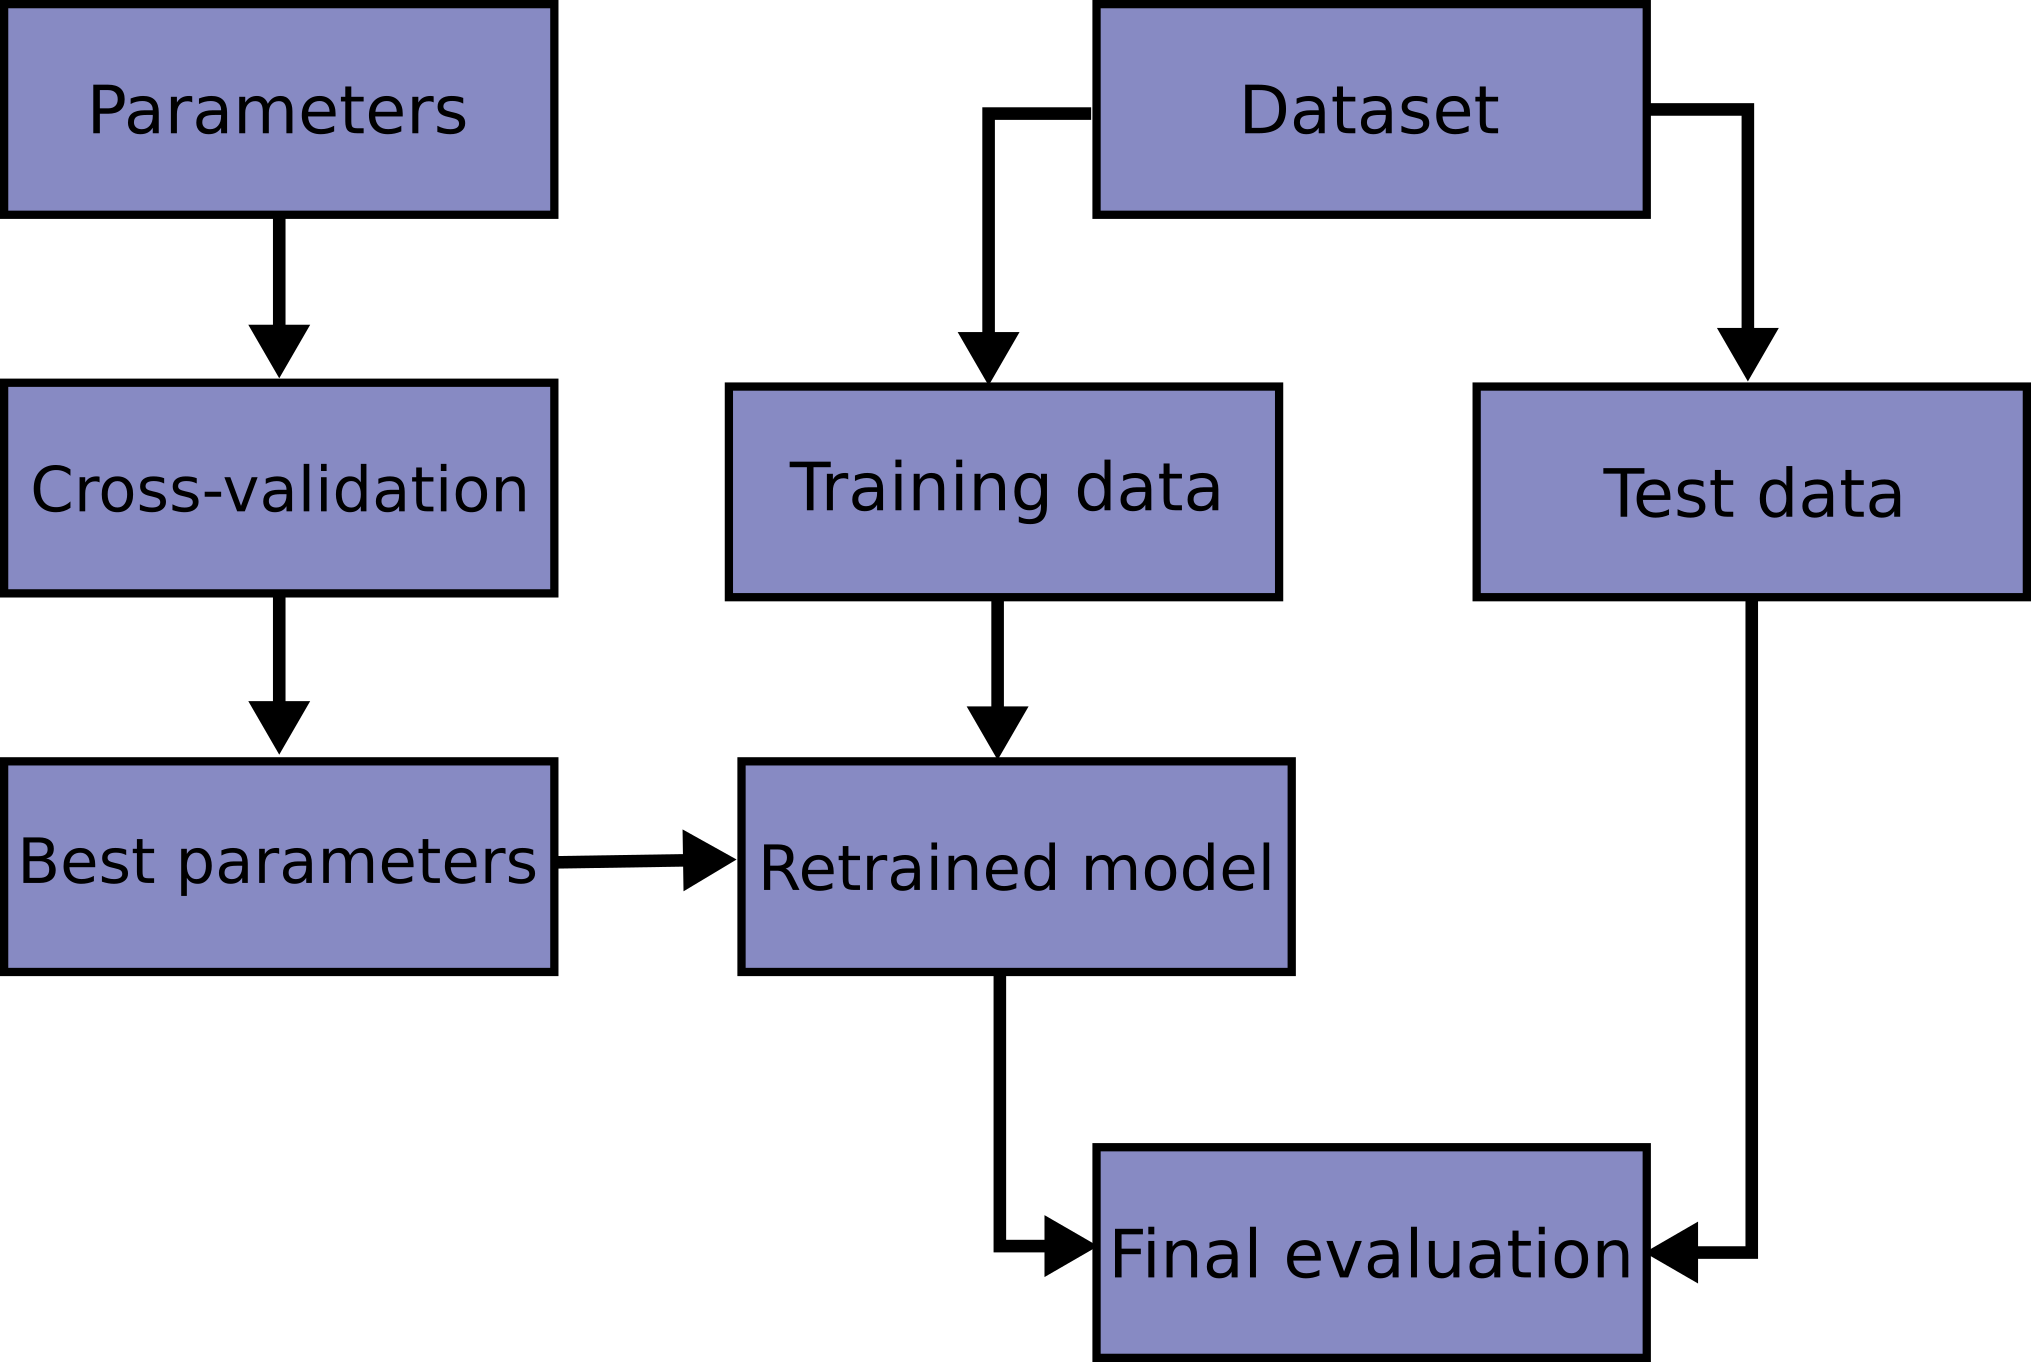

We will be using Ensembling methods in this notebook. I will only create one dataset for all models to use, but you can create multiple datasets, each to be used by a different set of models, depending on your use case.

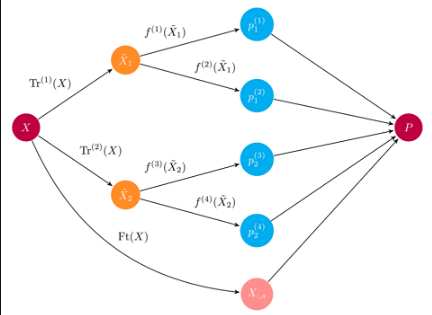

In [1]:
#import some necessary libraries
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import time

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
lam_l = 0.35
competition = 'SR'

from subprocess import check_output
#print(check_output(["ls", "-rlt", "../StackedRegression"]).decode("utf8")) #check the files available in the directory
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

StartTime = datetime.datetime.now()

In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

**Import libraries**

In [3]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

#from sklearn.metrics import mean_squared_log_error
# to run locally: conda install -c anaconda py-xgboost
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [4]:
train = pd.read_csv('HousePricesTrain.csv')
test = pd.read_csv('HousePricesTest.csv')
y_train = boxcox1p(train['SalePrice'], lam_l) 

train.drop("SalePrice", axis = 1, inplace = True)

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

alternate data source using top n features from Sequential Feature Selector (FeatureSelection.ipynb)

Reference: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

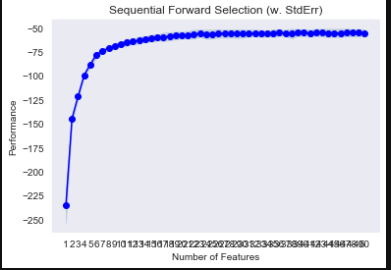

In [5]:
from copy import deepcopy
import pickle

with open('X_train_sfs50.pkl', 'rb') as fid:
    X_train_sfs = pickle.load(fid)
with open('X_test_sfs50.pkl', 'rb') as fid:
    X_test_sfs = pickle.load(fid)

In [6]:
subtrain, val, y_subtrain, y_val = train_test_split(train, y_train, test_size=0.33, random_state=42)

In [7]:
train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.886,5.831,19.212,0.730,0.730,1.541,0.000,2.440,1.820,14.188,...,0,0,0,1,0,0,0,0,1,0
1,2.056,6.221,19.712,0.730,0.730,1.541,0.000,2.260,2.440,14.145,...,0,0,0,1,0,0,0,0,1,0
2,2.886,5.915,20.347,0.730,0.730,0.000,0.000,2.440,1.820,14.184,...,0,0,0,1,0,0,0,0,1,0
3,3.011,5.685,19.692,0.730,0.730,0.000,0.000,2.440,1.820,14.048,...,0,0,0,1,1,0,0,0,0,0
4,2.886,6.315,21.325,0.730,0.730,0.000,0.000,2.603,1.820,14.183,...,0,0,0,1,0,0,0,0,1,0


In [8]:
test.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.056,6.221,20.479,0.730,0.730,1.541,0.000,2.056,2.056,14.121,...,0,0,0,1,0,0,0,0,1,0
1,2.056,6.245,21.327,0.730,0.730,0.000,0.000,2.260,2.056,14.117,...,0,0,0,1,0,0,0,0,1,0
2,2.886,6.073,21.197,0.730,0.730,0.000,0.000,2.056,1.820,14.178,...,0,0,0,1,0,0,0,0,1,0
3,2.886,6.173,19.865,0.730,0.730,0.000,0.000,2.260,2.056,14.180,...,0,0,0,1,0,0,0,0,1,0
4,0.000,5.094,17.257,0.730,0.730,0.000,0.000,2.603,1.820,14.170,...,0,0,0,1,0,0,0,0,1,0


**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has no shuffle attribute, so we add one line of code,  in order to shuffle the dataset  prior to cross-validation

replace cross_val_score() with cross_validate()
# reference: https://scikit-learn.org/stable/modules/cross_validation.html

    from sklearn.metrics import make_scorer
    scoring = {'prec_macro': 'precision_macro',
               'rec_macro': make_scorer(recall_score, average='macro')}
    scores = cross_validate(clf, X, y, scoring=scoring,
                            cv=5, return_train_score=True)
    sorted(scores.keys())
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
     'train_prec_macro', 'train_rec_macro']
    scores['train_rec_macro']
    array([0.97..., 0.97..., 0.99..., 0.98..., 0.98...])

Kfold is useful for thorough testing of a model, will give a more accurate score based on remove some data test on the remaining and change the data removed each time. See image below for details:

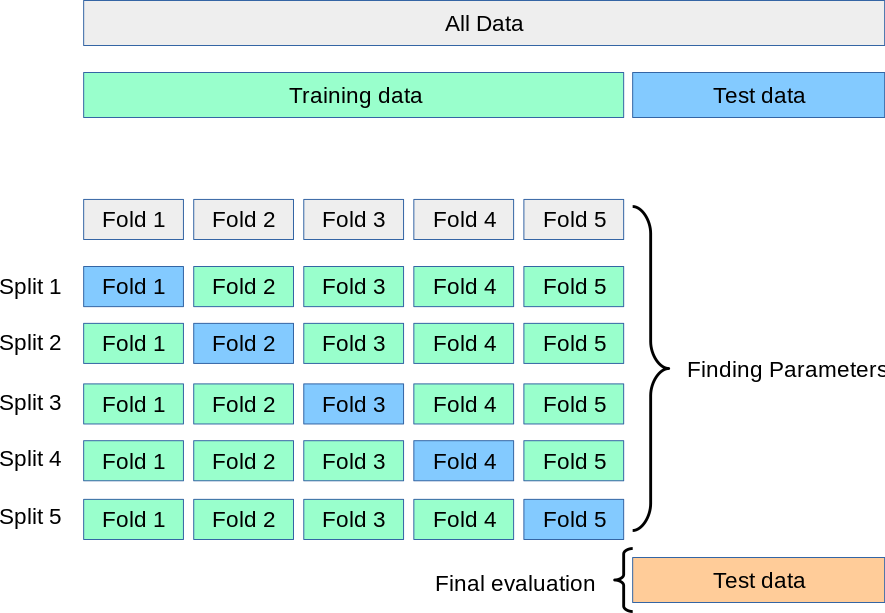

In [9]:
#Validation function
# train.values and y_train are both log scaled so just need to take the square of the delta between them to calculate the error, then take the sqrt to get rmsle
# but for now y_train is boxcox1p(), not log(). Use this to convert back: inv_boxcox1p(y_train, lam_l)
n_folds=5 # only for more accurate comparision, the number here does not affect the final score

def rmsle_cv(model):
    print("running rmsle_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf)) # also r2
    print("raw rmse scores for each fold:", rmse)
    return(rmse)

def r2_cv(model):
    print("running r2_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    r2= cross_val_score(model, train.values, y_train, scoring="r2", cv = kf) # also r2
    print("raw r2 scores for each fold:", r2)
    return(r2)

# used for another competition
def mae_cv(model):
    print("running mae_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    mae = -cross_val_score(model, train.values, y_train, scoring="neg_mean_absolute_error", cv = kf) # also r2
    print("raw mae scores for each fold:", mae)
    return(mae)

def all_cv(model, n_folds, cv):
    print("running cross_validate")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error', 
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    scores = cross_validate(model, train.values, y_train, scoring=scorers,
                           cv=kf, return_train_score=True)
    return(scores)

##Base models

In [10]:
def runGSCV(num_trials, features, y_values):
    non_nested_scores = np.zeros(num_trials) # INCREASES BIAS
    nested_scores = np.zeros(num_trials)
    # Loop for each trial
    for i in range(num_trials):
        print("Running GridSearchCV:")
        with MyTimer():    
            #grid_result = gsc.fit(train, y_train)  
            grid_result = gsc.fit(features, y_values)  
        non_nested_scores[i] = grid_result.best_score_
        if (competition == 'SR'):
            print("Best mae %f using %s" % ( -grid_result.best_score_, grid_result.best_params_))
        else:
            print("Best rmse %f using %s" % ( np.sqrt(-grid_result.best_score_), grid_result.best_params_))
        
        # nested/non-nested cross validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
        with MyTimer():    
            #nested_score = cross_val_score(gsc, X=train, y=y_train, cv=outer_cv, verbose=0).mean() 
            nested_score = cross_val_score(gsc, X=features, y=y_values, cv=outer_cv, verbose=0).mean() 
            # source code for cross_val_score is here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L137
        if (competition == 'SR'):
            print("nested mae score from KFold %0.3f" % -nested_score)
        else:
            print("nested rmse score from KFold %0.3f" % np.sqrt(-nested_score))
        
        nested_scores[i] = nested_score
        print('grid_result',grid_result)
        #if (competition == 'SR'):
        print("mean scores: r2(%0.3f) mae(%0.3f) nmse(%0.3f) nmsle(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), -grid_result.cv_results_['mean_test_mae'].mean(),  np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_nmsle'].mean() ))
        #print("mean scores: r2(%0.3f) nmse(%0.3f) mae(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_mae'].mean()))
    return grid_result


In [11]:
def calc_all_scores(model, n_folds=5, cv=5):
    scores = all_cv(model, n_folds, cv)
    #scores['train_<scorer1_name>'']
    #scores['test_<scorer1_name>'']
    print("\n mae_cv score: {:.4f} ({:.4f})\n".format( (-scores['test_mae']).mean(), scores['test_mae'].std() ))
    print("\n rmsle_cv score: {:.4f} ({:.4f})\n".format( (np.sqrt(-scores['test_nmse'])).mean(), scores['test_nmse'].std() ))
    print("\n r2_cv score: {:.4f} ({:.4f})\n".format( scores['test_r2'].mean(), scores['test_r2'].std() ))
    return (scores)

# useful when you can't decide on parameter setting from best_params_
# result_details(grid_result,'mean_test_nmse',100)
def result_details(grid_result,sorting='mean_test_nmse',cols=100):
    param_df = pd.DataFrame.from_records(grid_result.cv_results_['params'])
    param_df['mean_test_nmse'] = np.sqrt(-grid_result.cv_results_['mean_test_nmse'])
    param_df['std_test_nmse'] = np.sqrt(grid_result.cv_results_['std_test_nmse'])
    param_df['mean_test_mae'] = -grid_result.cv_results_['mean_test_mae']
    param_df['std_test_mae'] = -grid_result.cv_results_['std_test_mae']
    param_df['mean_test_r2'] = -grid_result.cv_results_['mean_test_r2']
    param_df['std_test_r2'] = -grid_result.cv_results_['std_test_r2']
    return param_df.sort_values(by=[sorting]).tail(cols)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mae(y, y_pred):
    return mean_absolute_error(y,y_pred)


List of possible scoring values:  
Regression  

‘explained_variance’ metrics.explained_variance_score  
‘max_error’ metrics.max_error  
‘neg_mean_absolute_error’ metrics.mean_absolute_error  
‘neg_mean_squared_error’ metrics.mean_squared_error  
‘neg_root_mean_squared_error’ metrics.mean_squared_error  
‘neg_mean_squared_log_error’ metrics.mean_squared_log_error  
‘neg_median_absolute_error’ metrics.median_absolute_error  
‘r2’ metrics.r2_score  
‘neg_mean_poisson_deviance’ metrics.mean_poisson_deviance  
‘neg_mean_gamma_deviance’ metrics.mean_gamma_deviance  

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline, also want to compare to StandardScaler() => RobustScaler() is slightly better

In [12]:
# initialize the algorithm for the GridSearchCV function
lasso = Lasso()
tuningLasso = 1 # takes 2 minutes to complete

if (tuningLasso == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.01,], # done, lower keeps getting better, but don't want to go too low and begin overfitting (alpha is related to L1 reg)
        'fit_intercept':[True], # done, big difference
        'normalize':[False], # done, big difference
        'precompute':[False], # done, no difference
        'copy_X':[True], # done, no difference
        'max_iter':[200], # done
        'tol':[0.005], # done, not much difference
        'warm_start':[False], # done, no difference
        'positive':[False], # done, big difference
        'random_state':[1],
        'selection':['cyclic'] # done both are same, cyclic is default
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.2],
        'fit_intercept':[True],
        'normalize':[False],
        'precompute':[False],
        'copy_X':[True],
        'max_iter':[200],
        'tol':[0.0001],
        'warm_start':[False],
        'positive':[False],
        'random_state':[None],
        'selection':['cyclic']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error', 
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'random_state',100)
rd[['random_state','alpha','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','alpha'])


Running GridSearchCV:
The function took 0.5377769470214844 seconds to complete
Best mae 63.619755 using {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}
The function took 1.1389904022216797 seconds to complete
nested mae score from KFold 64.127
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.01], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [200],
                         'normalize': [False], 'positive': [False],
                         'precompute': [False], 'random_state': [1],
                         'selection': ['cyclic'], 'tol': [0.005],
                         'warm_start': [False]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_er

,random_state,alpha,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,1,0.010,7.995,0.998,5.593,-0.257,-0.915,-0.010


In [13]:
tuning_lasso = 1
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1
lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_))
l = {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}
#l = "{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}"
#Lasso_new = make_pipeline(RobustScaler(), Lasso(**l))
#lasso_ss = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1 => worse score

In [14]:
if (tuning_lasso == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [lasso, lasso_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.3019757270812988 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.5485100746154785 seconds to complete


In [15]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1

if (tuning_lasso == 1):
    for i in [2,5,20,42,99]:
        from sklearn.linear_model import Lasso
        print('random_state =',i)

        l = {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}
        lasso_new = make_pipeline(RobustScaler(), Lasso(**l, random_state=i))
        #lasso_new = Lasso(**l, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [lasso, lasso_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_, random_state=i))

random_state = 2
running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.2326836585998535 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.6109757423400879 seconds to complete
                                               model   mae  rmsle    r2
1  (RobustScaler(), Lasso(alpha=0.01, max_iter=20... 5.577  7.969 0.916
0  (RobustScaler(), Lasso(alpha=0.0005, random_st... 5.905  8.568 0.903
random_state = 5
running cross_validate

 mae_cv score: 5.9049 (0.1957)


 rmsle_cv score: 8.5676 (9.7756)


 r2_cv score: 0.9033 (0.0062)

The function took 1.2873437404632568 seconds to complete
running cross_validate

 mae_cv score: 5.5770 (0.1787)


 rmsle_cv score: 7.9691 (8.6429)


 r2_cv score: 0.9163 (0.0071)

The function took 0.7993428707122803 seconds to complete
                              

In [16]:
model_results

[[Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso', Lasso(alpha=0.0005, random_state=1))]),
  5.904869719568312,
  8.567648254344649,
  0.9033417642124941],
 [Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso',
                   Lasso(alpha=0.01, max_iter=200, random_state=99, tol=0.005))]),
  5.576980775275713,
  7.969143058336821,
  0.9162749712325489]]

- **Elastic Net Regression** :

again made robust to outliers

combines Lasso L1 Linear regularization and Ridge L2 Quadratic/Squared regularization penalties together into one algorithm

In [17]:
# initialize the algorithm for the GridSearchCV function
ENet = ElasticNet()
tuningENet = 0 # takes 2 minutes to complete

if (tuningENet == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.005,0.01,0.05,0.1],
        'l1_ratio':[.6,.65,.7,.75,.8,.85,.9],
        'fit_intercept':[True], # ,False
        'normalize':[False], # True,
        'max_iter':range(50,500,50),
        'selection':['random'], # 'cyclic',
        'random_state':[None]
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.05],
        'l1_ratio':[.85],
        'fit_intercept':[True],
        'normalize':[False],
        'max_iter':[100], # default 1000
        'selection':['random']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ENet,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['alpha','l1_ratio','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 0.24399995803833008 seconds to complete
Best mae 65.065100 using {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
The function took 0.6636793613433838 seconds to complete
nested mae score from KFold 65.105
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.05], 'fit_intercept': [True],
                         'l1_ratio': [0.85], 'max_iter': [100],
                         'normalize': [False], 'selection': ['random']},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.914) mae(5.679) nmse(8.066) nmsle(-0.002)
Running GridSearchCV:
The function took 0.17080283164978027 seconds

,alpha,l1_ratio,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,0.050,0.850,7.996,2.048,5.675,-0.117,-0.916,-0.007


In [18]:
#ENet_orig = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = make_pipeline(StandardScaler(), ElasticNet(**grid_result.best_params_, random_state=3))
ENet_new = make_pipeline(RobustScaler(), ElasticNet(**grid_result.best_params_, random_state=3))


- **Kernel Ridge Regression** :

In [19]:
tune_kr = 1
if (tune_kr == 1):
    # initialize the algorithm for the GridSearchCV function
    KRR = KernelRidge()
    tuningKRR = 0 # this took 40 mins, 20 per iteration

    if (tuningKRR == 1):
        # use this when tuning
        param_grid={
            'alpha':[2.2,2.4], 
            'kernel':['polynomial'], #for entire list see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.kernel_metrics.html#sklearn.metrics.pairwise.kernel_metrics
            'gamma':[0.0001,0.001,0.01,0.1],
            'degree':[1,2,3,4,5,6], 
            'coef0':[0.1,0.3,0.5,1.0,2.0]
        }

    else:
        # use this when not tuning
        # nmse: Best mae 583416973.611280 using {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
        # mae: Best mae 15805.764347 using {'alpha': 2.0, 'coef0': 0.1, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
        param_grid={
            'alpha':[2.2], 
            'kernel':['polynomial'], # 'linear', 'rbf'
            'gamma':[0.001],
            'degree':[4], 
            'coef0':[1.0]
        }
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=KRR,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)

    rd = result_details(grid_result,'mean_test_nmse',100)
    rd[['alpha','degree','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 1.1594865322113037 seconds to complete
Best mae 57.342639 using {'alpha': 2.2, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'kernel': 'polynomial'}
The function took 3.245006799697876 seconds to complete
nested mae score from KFold 59.573
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=KernelRidge(),
             param_grid={'alpha': [2.2], 'coef0': [1.0], 'degree': [4],
                         'gamma': [0.001], 'kernel': ['polynomial']},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.924) mae(5.370) nmse(7.572) nmsle(-0.002)
Running GridSearchCV:
The function took 1.095071792602539 seconds to complete
Best mae 59.071062 using {'alpha': 2.2, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'ker

In [20]:
#KRR_orig = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#KRR = KernelRidge(**grid_result.best_params_)
krr = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
KRR = KernelRidge(**krr)
#KRR = KernelRidge(alpha=2.2, coef0=0.5, degree=5, gamma=0.001, kernel='polynomial')

if (tune_kr == 1):
    KRR_new = KernelRidge(**grid_result.best_params_)
else:
    krr_new = {'alpha': 2.3, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'kernel': 'polynomial'}
    KRR_new = KernelRidge(**krr)

- **Random Forest Regressor** :

This model needs improvement, will run cross validate on it

In [21]:
# initialize the algorithm for the GridSearchCV function
rf = RandomForestRegressor()
tuningRF = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningRF == 1):
    # use this when tuning
    param_grid={
        'max_depth':[3,4,5],
        'max_features':[None,'sqrt','log2'], 
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators':range(25,100,25), 
        #'class_weight':[None,'balanced'],  
        'min_samples_leaf':range(5,15,5), 
        'min_samples_split':range(10,30,10), 
        'criterion':['mse', 'mae'] 
    }

else:
    # use this when not tuning
    param_grid={
        'max_depth':[5],
        'max_features':[None], # max_features is None is default and works here, removing 'sqrt','log2'
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators': [50], # number of trees selecting 100, removing range(50,126,25)
        #'class_weight':[None], # None was selected, removing 'balanced'
        'min_samples_leaf': [5], #selecting 10, removing range 10,40,10)
        'min_samples_split': [10], # selecting 20, removing range(20,80,10),
        'criterion':['mse'] # remove gini as it is never selected
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 3.282322883605957 seconds to complete
Best mae 100.693176 using {'criterion': 'mse', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
The function took 15.685736179351807 seconds to complete
nested mae score from KFold 105.355
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [5],
                         'max_features': [None], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [50]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.868) mae(7.159) nmse(10.035) nmsle(-0.003)
Running GridSearchCV:
The function 

,n_estimators,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,50,10.178,4.271,7.189,-0.444,-0.862,-0.024


In [22]:
#RF_orig = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=3,n_estimators=500))
RF = make_pipeline(StandardScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good
RF_new = make_pipeline(RobustScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good

In [23]:
print("Optimize GBoost: ", datetime.datetime.now())

Optimize GBoost:  2020-07-31 21:06:37.540716


- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

Optimize

In [24]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5) # was 5
# learning_ratefloat, default=0.1
# learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
tuning_gb = 0
if (tuning_gb == 1):
    # initialize the algorithm for the GridSearchCV function
    GBoost_new = GradientBoostingRegressor()
    tuningGB = 1
    if (tuningGB == 1):
        # use this when tuning
        param_grid={
            #'loss':['ls','lad','huber','quantile'],
            'loss':['huber'], # done
            'learning_rate':[0.05],
            'n_estimators':[3000], # done
            'subsample':[1.0],
            #'criterion':['friedman_mse','mse','mae'],
            'criterion':['friedman_mse'], # done
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2,3,4], # done
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            #'max_features':[None,'auto','sqrt','log2'],
            'max_features':['sqrt'], # done
            'alpha':[0.60], # done
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5,20,42]
        }
    else:
        # use this when not tuning
        param_grid={
            'loss':['huber'], 
            'learning_rate':[0.05],
            'n_estimators':[3000], 
            'subsample':[1.0],
            'criterion':['friedman_mse'], 
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2], 
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            'max_features':['sqrt'], 
            'alpha':[0.60], 
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5]
        }
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=GBoost_new,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, subtrain, y_subtrain)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['criterion','max_depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


,criterion,max_depth,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,mse,5,10.178,4.271,7.189,-0.444,-0.862,-0.024


In [25]:
rd[['criterion','max_depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['criterion','max_depth'])


,criterion,max_depth,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,mse,5,10.178,4.271,7.189,-0.444,-0.862,-0.024


I am getting conflicting results for  best params, sometimes huber or lad and sometimes friedman_mse or mae, so will look at more detailed output. This style output is much more useful for deciding between parameter values, adding the different random states shows the consistency, or lack of, for each setting

maybe do a groupby to make this table more manageable and easier to read

In [26]:
if (tuning_gb == 1):
    GBoost_new = GradientBoostingRegressor(**grid_result.best_params_)
else:
    gbr  = {'alpha': 0.6, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 15, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3000, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 5, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    GBoost_new = GradientBoostingRegressor(**gbr)

In [27]:
if (tuning_gb == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

In [28]:
if (tuning_gb == 1):
    GBoost.fit(subtrain.values, y_subtrain)
    gboost_train_pred = inv_boxcox1p(GBoost.predict(subtrain.values), lam_l)
    gboost_val_pred = inv_boxcox1p(GBoost.predict(val.values), lam_l)
    print('GBoost')
    print('train results')
    print(mae(y_subtrain, gboost_train_pred))
    print(rmsle(y_subtrain, gboost_train_pred))
    print('test results')
    print(mae(y_val, gboost_val_pred))
    print(rmsle(y_val, gboost_val_pred))

    GBoost_new.fit(subtrain.values, y_subtrain)
    gboost_train_pred = inv_boxcox1p(GBoost_new.predict(subtrain.values), lam_l)
    gboost_val_pred = inv_boxcox1p(GBoost_new.predict(val.values), lam_l)
    print('GBoost_new')
    print('train results')
    print(mae(y_subtrain, gboost_train_pred))
    print(rmsle(y_subtrain, gboost_train_pred))
    print('test results')
    print(mae(y_val, gboost_val_pred))
    print(rmsle(y_val, gboost_val_pred))

In [29]:
if (tuning_gb == 1):
    GBoost_new.fit(train.values, y_train)
    gboost_test_pred = inv_boxcox1p(GBoost_new.predict(test.values), lam_l)
    gboost_test_pred
    sub = pd.DataFrame()
    #sub['Id'] = test['Id']
    sub['Id'] = test_ID
    sub['SalePrice'] = gboost_test_pred
    sub.to_csv('submission.csv',index=False)

In [30]:
if (tuning_gb == 1):
    GBoost.fit(train.values, y_train)
    gboost_test_pred = inv_boxcox1p(GBoost.predict(test.values), lam_l)
    gboost_test_pred
    sub = pd.DataFrame()
    #sub['Id'] = test['Id']
    sub['Id'] = test_ID
    sub['SalePrice'] = gboost_test_pred
    sub.to_csv('submission.csv',index=False)

- **Additional testing**

Compare any random state

In [31]:
if (tuning_gb == 1):

    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **XGBoost** :

In [32]:
print("Optimize XGB: ", datetime.datetime.now())

Optimize XGB:  2020-07-31 21:06:38.069243


In [33]:
tuning_xgb = 0
if (tuning_xgb == 1):
    # initialize the algorithm for the GridSearchCV function# initialize the algorithm for the GridSearchCV function
    xgb1 = xgb.XGBRegressor()
    tuningXGB = 1 # this took 2 hours last time, 1 hour per iteration

    if (tuningXGB == 1):
        # use this when tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468], # done - all values almost identical results
            'colsample_bylevel':[0.3], # done - all give same result
            'objective':['reg:squarederror'], # done - Default:'reg:squarederror', None, reg:pseudohubererror, reg:squaredlogerror, reg:gamma
            'booster':['gbtree'], # done - Default: 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04], # done
            'max_depth':[3], # - done
            'importance_type':['gain'], # done - all give same value, Default:'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817], # done - no difference with several values
            'n_estimators':[1000], # done
            'reg_alpha':[0.4], # done
            'reg_lambda':[0.8571], # done
            'subsample':[0.5], # done
            'silent':[1],
            'random_state':[35],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'], # done - all options have same results  Default:rmse for regression rmse, mae, rmsle, logloss, cox-nloglik
            #'nthread ':[-1],
            'verbosity':[0]
        }

    else:
        # use this when not tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468],
            'colsample_bylevel':[0.3],
            'objective':['reg:squarederror'], # 'binary:logistic', 'reg:squarederror', 'rank:pairwise', None
            'booster':['gbtree'], # 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04],
            'max_depth':[3],
            'importance_type':['gain'], # 'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817],
            'n_estimators':[1000],
            'reg_alpha':[0.4],
            'reg_lambda':[0.8571],
            'subsample':[0.5],
            'silent':[1],
            'random_state':[35],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'],
            #'nthread ':[-1],
            'nthread ':[-1],
            'verbosity':[0]
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=xgb1,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


xgb reference: https://xgboost.readthedocs.io/en/latest/parameter.html

In [34]:
if (tuning_xgb == 1):
    rd = result_details(grid_result,'mean_test_nmse',100)

    rd[['random_state','eval_metric','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])


In [35]:
model_xgb = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                             learning_rate=0.05, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=35) # was random_state=7, cannot set to None 
# maybe an issue with silent=1...

if (tuning_xgb == 1):
    import xgboost as xgb
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        model_xgb_new = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.45, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new2 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new3 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None

        model_results = [] # model flow, mae, rmsle
        models = [model_xgb, model_xgb_new, model_xgb_new2, model_xgb_new3]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    model_xgb_new = xgb.XGBRegressor(**grid_result.best_params_)

Visualize the results

In [36]:
#import graphviz
#model_xgb.fit(train, y_train,  verbose=False) #  eval_set=[(X_test, y_test)]
#xgb.plot_importance(model_xgb)
#xgb.to_graphviz(model_xgb, num_trees=20)

In [37]:
print("Optimize LightGBM: ", datetime.datetime.now())

Optimize LightGBM:  2020-07-31 21:06:38.466741


- **LightGBM** :

In [38]:
tuning_lgb = 0
if (tuning_lgb == 1):
    # initialize the algorithm for the GridSearchCV function
    #model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=- 1, 
    #                            subsample_for_bin=200000, 
    #                            objective='regression',num_leaves=5,
    #                            learning_rate=0.05, n_estimators=720,
    #                            class_weight=None, min_split_gain=0.0, 
    #                            min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
    #                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
    #                            random_state=None, n_jobs=- 1, silent=True, importance_type='split')

    lgb1 = lgb.LGBMRegressor()
    tuningLGB = 0

    if (tuningLGB == 1):
        # use this when tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5,6], # - done
            'learning_rate':[0.05], # - done
            'n_estimators':[650,750], # - done
            'max_bin':[45,55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[500,1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }
    else:
        # use this when not tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5], # - done, maybe 5 is okay too
            'learning_rate':[0.05], # - done
            'n_estimators':[650], # - done
            'max_bin':[55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=lgb1,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


In [39]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9, random_state=10,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
if (tuning_lgb == 1):
    model_lgb_new = lgb.LGBMRegressor(**grid_result.best_params_)
else:
    lgbm = {'bagging_fraction': 0.85, 'bagging_freq': 5, 'bagging_seed': 9, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'feature_fraction': 0.2319, 'feature_fraction_seed': 9, 'importance_type': 'split', 'learning_rate': 0.05, 'max_bin': 55, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_data_in_leaf': 9, 'min_split_gain': 0.0, 'min_sum_hessian_in_leaf': 11, 'n_estimators': 650, 'num_leaves': 5, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 1000, 'subsample_freq': 0}
    model_lgb_new = lgb.LGBMRegressor(**lgbm)

- **BayesianRidge** :

In [40]:
# initialize the algorithm for the GridSearchCV function
br = BayesianRidge()
tuningBR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningBR == 1):
    # use this when tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

else:
    # use this when not tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=br,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 2.2565102577209473 seconds to complete
Best mae 63.175322 using {'alpha_1': 1e-06, 'alpha_2': 1e-05, 'alpha_init': None, 'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 50, 'normalize': False, 'tol': 0.001, 'verbose': False}
The function took 8.372122287750244 seconds to complete
nested mae score from KFold 64.077
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=BayesianRidge(),
             param_grid={'alpha_1': [1e-06], 'alpha_2': [1e-05],
                         'alpha_init': [None], 'compute_score': [True, False],
                         'copy_X': [True], 'fit_intercept': [True, False],
                         'lambda_1': [1e-05], 'lambda_2': [1e-06],
                         'lambda_init': [None], 'n_iter': [50],
                         'normalize': [False, True], 'tol': [0.001],
                      

In [41]:
tuning_br = 0
BR = BayesianRidge()
if (tuning_br == 1):
    BR_new = BayesianRidge(**grid_result.best_params_)

In [42]:
rd = result_details(grid_result,'alpha_1',100)
rd[['alpha_1','alpha_2','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

,alpha_1,alpha_2,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,0.000,0.000,8.074,2.923,5.645,-0.394,-0.914,-0.000
1,0.000,0.000,8.223,2.946,5.681,-0.404,-0.911,-0.002
2,0.000,0.000,8.104,2.906,5.678,-0.386,-0.914,-0.001
3,0.000,0.000,8.104,2.906,5.678,-0.386,-0.914,-0.001
4,0.000,0.000,8.074,2.923,5.645,-0.394,-0.914,-0.000
5,0.000,0.000,8.223,2.946,5.681,-0.404,-0.911,-0.002
6,0.000,0.000,8.104,2.906,5.678,-0.386,-0.914,-0.001
7,0.000,0.000,8.104,2.906,5.678,-0.386,-0.914,-0.001


In [43]:
if (tuning_br == 1):
    model_results = [] # model flow, mae, rmsle
    models = [BR, BR_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **More Models** :

In [44]:
# initialize the algorithm for the GridSearchCV function
# defaults are best
ET = ExtraTreesRegressor()
tuningET = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningET == 1):
    # use this when tuning
    param_grid={
        'n_estimators':[100], # revisit at possibly 2000, but this algorithm becomes really slow for large values
        'criterion':['mse'], # done Default: mse, mae
        'max_depth':[None], # done - above 30 result converges to None
        'min_samples_split':[2], # done - inconsistently better
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'], # done - Default:“auto”, “sqrt”, “log2”, None
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False], # done - True doesn't work, results in a nan value
        'n_jobs':[None],
        'random_state':[1,5,42,55,98],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None] # done - no difference
    }

else:
    # use this when not tuning
    param_grid={
        'n_estimators':[100],
        'criterion':['mse'],
        'max_depth':[None],
        'min_samples_split':[2],
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False],
        'n_jobs':[None],
        'random_state':[None],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ET,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 13.697174072265625 seconds to complete
Best mae 73.219336 using {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
The function took 43.75502395629883 seconds to complete
nested mae score from KFold 72.189
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [False], 'ccp_alpha': [0.0],
                         'criterion': ['mse'], 'max_depth': [None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrea

In [45]:
rd = result_details(grid_result,'mean_test_nmse',100)
rd[['random_state','n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

,random_state,n_estimators,mean_test_nmse,std_test_nmse,mean_test_mae,std_test_mae,mean_test_r2,std_test_r2
0,None,100,8.516,3.585,5.952,-0.485,-0.905,-0.010


In [46]:
#ET = make_pipeline(RobustScaler(), ExtraTreesRegressor()) # was 1 Tree algorithms don't need scaling
tuning_et = 0
if (tuning_et == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)
        ET = ExtraTreesRegressor(random_state=i)
        #ET2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(random_state=i))

        e = {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'verbose': 0, 'warm_start': False}
        ET_new = ExtraTreesRegressor(**e, random_state=i)
        #ET_new2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(**e, random_state=i))

        model_results = [] # model flow, mae, rmsle
        models = [ET, ET_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    ET_new = make_pipeline(RobustScaler(), ExtraTreesRegressor(**grid_result.best_params_))

In [47]:
# initialize the algorithm for the GridSearchCV function
R = Ridge(alpha=1.0)
tuningR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningR == 1):
    # use this when tuning
    param_grid={
        'alpha':[8], # done
        'fit_intercept':[True], # done
        'normalize':[False], # done
        'copy_X':[True],
        'max_iter':[None], # done - no difference
        'tol':[0.001],
        'solver':['auto'], # done - Default:‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
        'random_state':[1,10,42,99,127]
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[1.0],
        'fit_intercept':[True],
        'normalize':[False],
        'copy_X':[True],
        'max_iter':[None],
        'tol':[0.001],
        'solver':['auto'],
        'random_state':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=R,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 0.8198373317718506 seconds to complete
Best mae 65.430598 using {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 1, 'solver': 'auto', 'tol': 0.001}
The function took 2.7981886863708496 seconds to complete
nested mae score from KFold 63.378
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [8], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [None],
                         'normalize': [False],
                         'random_state': [1, 10, 42, 99, 127],
                         'solver': ['auto'], 'tol': [0.001]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r

In [48]:
rd = result_details(grid_result,'mean_test_nmse',100)
summary = rd[['alpha','random_state','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])
#summary.groupby(['fit_intercept'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_nmse': 'std', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])
summary.groupby(['alpha'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])


,alpha,mean_test_nmse,mean_test_mae,mean_test_r2
0,8,7.909,5.567,-0.916


In [49]:
#R = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1)) # was 1
tuning_r = 0
if (tuning_r == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        r= {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001}
        #R_new = make_pipeline(RobustScaler(), Ridge(**r, random_state=i))
        R_new = Ridge(**r, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [R, R_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    #R_new = make_pipeline(RobustScaler(), Ridge(**grid_result.best_params_))
    R_new = Ridge(**grid_result.best_params_)

- **CatBoost**

Reference: https://catboost.ai/docs/concepts/python-reference_parameters-list.html

In [50]:
#CBoost = CatBoostRegressor(logging_level='Silent',random_seed=0)
CBoost = CatBoostRegressor(logging_level='Silent', random_state=0, depth=6, n_estimators=1000,eval_metric='RMSE',bagging_temperature=1,grow_policy='SymmetricTree',bootstrap_type='MVS') # l2_leaf_reg, learning_rate unknown

In [51]:
tuning_cb = 0
if (tuning_cb == 1):
    # initialize the algorithm for the GridSearchCV function
    cb = CatBoostRegressor()
    if (tuningCB == 1):
        # use this when tuning
        param_grid={
            'nan_mode':['Min'],
            'eval_metric':['RMSE'],
            'iterations':[1000],
            'sampling_frequency':['PerTree'],
            'leaf_estimation_method':['Newton'],
            'grow_policy':['SymmetricTree'],
            'penalties_coefficient':[1],
            'boosting_type':['Plain'],
            'model_shrink_mode':['Constant'],
            'feature_border_type':['GreedyLogSum'],
            #'bayesian_matrix_reg':[0.10000000149011612],
            'l2_leaf_reg':[3],
            'random_strength':[1],
            'rsm':[1],
            'boost_from_average':[True],
            'model_size_reg':[0.5],
            'subsample':[0.800000011920929],
            'use_best_model':[False],
            'random_seed':[0,2,15],
            'depth':[6], # done
            'border_count':[254],
            #'classes_count':[0],
            #'auto_class_weights':['None'],
            'sparse_features_conflict_fraction':[0],
            'leaf_estimation_backtracking':['AnyImprovement'],
            'best_model_min_trees':[1],
            'model_shrink_rate':[0],
            'min_data_in_leaf':[1],
            'loss_function':['RMSE'],
            'learning_rate':[0.04174000024795532],
            'score_function':['Cosine'],
            'task_type':['CPU'],
            'leaf_estimation_iterations':[1],
            'bootstrap_type':['MVS'],
            'max_leaves':[31],
            'logging_level':['Silent']
        }

    else:
        # use this when not tuning
        param_grid={
            'nan_mode':['Min'],
            'eval_metric':['RMSE'],
            'iterations':[4000],
            'sampling_frequency':['PerTree'],
            'leaf_estimation_method':['Newton'],
            'grow_policy':['SymmetricTree'],
            'penalties_coefficient':[1],
            'boosting_type':['Plain'],
            'model_shrink_mode':['Constant'],
            'feature_border_type':['GreedyLogSum'],
            #'bayesian_matrix_reg':[0.10000000149011612],
            'l2_leaf_reg':[3],
            'random_strength':[1],
            'rsm':[1],
            'boost_from_average':[True],
            'model_size_reg':[0.5],
            'subsample':[0.800000011920929],
            'use_best_model':[False],
            'random_seed':[0],
            'depth':[6],
            'border_count':[254],
            #'classes_count':[0],
            #'auto_class_weights':['None'],
            'sparse_features_conflict_fraction':[0],
            'leaf_estimation_backtracking':['AnyImprovement'],
            'best_model_min_trees':[1],
            'model_shrink_rate':[0],
            'min_data_in_leaf':[1],
            'loss_function':['RMSE'],
            'learning_rate':[0.04174000024795532],
            'score_function':['Cosine'],
            'task_type':['CPU'],
            'leaf_estimation_iterations':[1],
            'bootstrap_type':['MVS'],
            'max_leaves':[31],
            'logging_level':['Silent']
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=cb,
        param_grid=param_grid,
        #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse'#, # use this one for optimizing
        #plot=True
    )
    grid_result = runGSCV(2, train, y_train)
    rd = result_details(grid_result,'depth',100)
    rd[['random_state','depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

In [52]:
tuning_cb = 0
a='''
if (tuning_cb == 1):
    CBoost_new = CatBoostRegressor(**grid_result.best_params_)
else:
    cbr = {'best_model_min_trees': 1, 'boost_from_average': True, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'border_count': 254, 'depth': 6, 'eval_metric': 'RMSE', 'feature_border_type': 'GreedyLogSum', 'grow_policy': 'SymmetricTree', 'iterations': 1000, 'l2_leaf_reg': 3, 'leaf_estimation_backtracking': 'AnyImprovement', 'leaf_estimation_iterations': 1, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.04174000024795532, 'logging_level': 'Silent', 'loss_function': 'RMSE', 'max_leaves': 64, 'min_data_in_leaf': 1, 'model_shrink_mode': 'Constant', 'model_shrink_rate': 0, 'model_size_reg': 0.5, 'nan_mode': 'Min', 'penalties_coefficient': 1, 'random_seed': 0, 'random_strength': 1, 'rsm': 1, 'sampling_frequency': 'PerTree', 'score_function': 'Cosine', 'sparse_features_conflict_fraction': 0, 'subsample': 0.800000011920929, 'task_type': 'CPU', 'use_best_model': False}
    CBoost_new = CatBoostRegressor(**cbr)'''

In [53]:
a='''
rd = result_details(grid_result,'mean_test_nmse',100)
summary = rd[['depth','random_state','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])
#summary.groupby(['fit_intercept'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_nmse': 'std', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])
summary.groupby(['depth'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])
'''

In [54]:
#R = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1)) # was 1
if (tuning_cb == 1):
    for i in [2,5,20,42,99]:
        print('random_state =', i)
        #CBoost     = CatBoostRegressor(logging_level='Silent', random_state=i) # don't touch this variable
        #CBoost_def = CatBoostRegressor(logging_level='Silent', random_state=i, depth=6, n_estimators=1000,eval_metric='RMSE',bagging_temperature=1,grow_policy='SymmetricTree',bootstrap_type='MVS') # l2_leaf_reg, learning_rate unknown    
        #R_new = make_pipeline(RobustScaler(), Ridge(**r, random_state=i))
        # 'max_leaves': 64, creates nan values, default of 31 is fine, or remove entirely...
        CBoost_new = CatBoostRegressor(**grid_result.best_params_) 

        model_results = [] # model flow, mae, rmsle
        models = [CBoost, CBoost_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            model_results.append([model.get_params(), (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    #R_new = make_pipeline(RobustScaler(), Ridge(**grid_result.best_params_))
    CBoost_new = CatBoostRegressor(logging_level='Silent', random_state=15, depth=5, l2_leaf_reg=1.0, n_estimators=1700,eval_metric='RMSE',learning_rate=0.025,random_strength=3.7,bagging_temperature=1.0,grow_policy='SymmetricTree',bootstrap_type='Bayesian')#,bayesian_matrix_reg=0.10000000149011612)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:  6.1min finished

[2020-07-31 21:15:18] Features: 1/2 -- score: -235.74105066907396[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed: 10.7min finished

[2020-07-31 21:26:00] Features: 2/2 -- score: -144.87159640174195

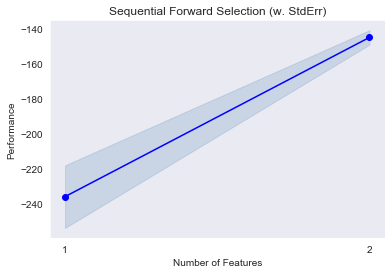

In [55]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# accuracy levels off at k_features=25, this code takes several hours to run!!
feature_select = 1
if (feature_select == 1):
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS

    sfs1 = SFS(CBoost_new, 
               k_features=2, 
               forward=True, 
               floating=False, 
               verbose=2,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(train, y_train)

    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    import matplotlib.pyplot as plt

    fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()

In [56]:
CBoost_new.fit(train,y_train)
import pickle
with open('CBoost_new.pkl', 'wb') as fid:
    pickle.dump(CBoost_new, fid)    
# load it again
with open('CBoost_new.pkl', 'rb') as fid:
    CBoost_new2 = pickle.load(fid)

In [64]:
CBoost_new2.predict(train[0:1])

array([204.17639742])

In [65]:
AB = AdaBoostRegressor()
from sklearn.svm import SVR
SVR = SVR()
DT = DecisionTreeRegressor()
KN = KNeighborsRegressor()
B = BaggingRegressor()

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [66]:
if (tuning_gb == 1):
    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_new]# model_lgb_new, lasso_ns, 

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

Calculate Metrics for model list

In [67]:
print("Calculate Metrics: ", datetime.datetime.now())

Calculate Metrics:  2020-07-31 20:18:43.211982


In [68]:
compare_models = 0
if (compare_models == 1):
    model_results = [] # model flow, mae, rmsle
    # GBoost_new is better than GBoost, but has lower final score, think this may be  overfitting
    # BR_new has same results, here, but better final score
    models = [lasso, lasso_new, model_lgb, ENet, ENet_new, KRR, GBoost, GBoost_new, model_xgb, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B, R, R_new, CBoost, CBoost_new] # worse or same: BR_new, model_lgb_new, lasso_ns, model_xgb_new,

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        try:
            print(model)
            label = model
        except KeyError as err:
            print("KeyError error: {0}".format(err))
            label = model.__class__()
        except Exception as e:
            print(e.message, e.args)
            label = model.__class__()
        finally:
            print("Continue") 
        print('label', label)    
        #model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])
        model_results.append([label, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

In [69]:
df_mr.sort_values(by=['rmsle'])

,model,mae,rmsle,r2
1,"(RobustScaler(), Lasso(alpha=0.01, max_iter=20...",5.577,7.969,0.916
0,"(RobustScaler(), Lasso(alpha=0.0005, random_st...",5.905,8.568,0.903


In [70]:
print("Stacking and Ensembling: ", datetime.datetime.now())

Stacking and Ensembling:  2020-07-31 20:18:43.288110


##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn BaseEstimator, RegressorMixin, TransformerMixin classes with our model and also to leverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

In [71]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them (can try median also)
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        # IDEA: return weighted means
        return np.mean(predictions, axis=1)


**Averaged base models score**

We just average five models here **XGBoost, GBoost, BayesianRidge, KRR and LightGBM**.  Of course we could easily add more models in the mix. 

try votingRegressor, it allows different weighting for each model

In [72]:
BR.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}

In [73]:
#use_voting_regressor = 0 # AveragingModels Averages
use_voting_regressor = 1 # VotingRegressor Averages 
#CBoost_new_10 = CatBoostRegressor(logging_level='Silent', random_state=10, depth=5, l2_leaf_reg=1.0, n_estimators=1700,eval_metric='RMSE',learning_rate=0.025,random_strength=3.7,bagging_temperature=1.0,grow_policy='SymmetricTree',bootstrap_type='Bayesian')

with MyTimer():
    if (use_voting_regressor == 1):
        print("running VotingRegressor")
        from sklearn.ensemble import VotingRegressor
        estimator_list = [('CBoost', CBoost_new),('xgb',model_xgb),('ENet',ENet),('gboost',GBoost),('krr',KRR),('br',BR)]
        weight_list = [4,2,2,2,2,2]
        averaged_models = VotingRegressor(estimators=estimator_list, weights=weight_list) 
        averaged_models.fit(train.values, y_train)
        averaged_train_pred = averaged_models.predict(train.values)
        averaged_pred = inv_boxcox1p(averaged_models.predict(test.values), lam_l)
    else:
        print("running AveragingModels")
        #AveragingModels will fit and predict each model and predict using the mean of the individual predictions
        averaged_models = AveragingModels(models = (CBoost_new,model_xgb,ENet,GBoost,KRR,BR))# ENet, model_xgb)) # Adding ENet and RF is worse, model_xgb_new is worse        
        averaged_models.fit(train.values, y_train)
        averaged_train_pred = averaged_models.predict(train.values)
        averaged_pred = inv_boxcox1p(averaged_models.predict(test.values), lam_l)

show_metrics = 0
if (show_metrics == 1):
    score = mae_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    score = rmsle_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))        

    print(mae(y_train, averaged_train_pred))
    print(rmsle(y_train, averaged_train_pred))
print(averaged_pred)

running VotingRegressor
The function took 42.37325406074524 seconds to complete
[122580.82167104 165518.65541358 188617.41900606 ... 167005.45975803
 113219.74228136 221108.89332417]


Compare different predictions to each other:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html

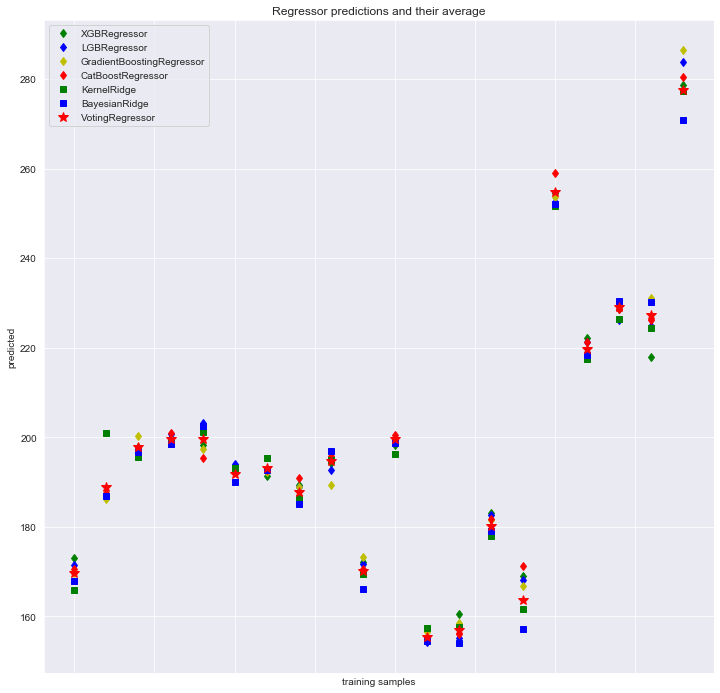

In [74]:
if (use_voting_regressor == 1):
    model_xgb.fit(train, y_train)
    model_lgb.fit(train, y_train)
    GBoost.fit(train, y_train)
    CBoost.fit(train, y_train)
    KRR.fit(train, y_train)
    BR.fit(train, y_train)
    averaged_models2 = VotingRegressor(estimators=estimator_list, weights=weight_list) 
    averaged_models2.fit(train, y_train)

    xt = test[:20]

    pred1 = model_xgb.predict(xt)
    pred2 = model_lgb.predict(xt)
    pred3 = GBoost.predict(xt)
    pred4 = CBoost.predict(xt)
    pred5 = KRR.predict(xt)
    pred6 = BR.predict(xt)
    pred7 = averaged_models2.predict(xt)
    plt.figure(figsize=(12,12))
    plt.plot(pred1, 'gd', label='XGBRegressor')
    plt.plot(pred2, 'bd', label='LGBRegressor')
    plt.plot(pred3, 'yd', label='GradientBoostingRegressor')
    plt.plot(pred4, 'rd', label='CatBoostRegressor')
    plt.plot(pred5, 'gs', label='KernelRidge')
    plt.plot(pred6, 'bs', label='BayesianRidge')
    plt.plot(pred7, 'r*', ms=10, label='VotingRegressor')

    plt.tick_params(axis='x', which='both', bottom=False, top=False,
                    labelbottom=False)
    plt.ylabel('predicted')
    plt.xlabel('training samples')
    plt.legend(loc="best")
    plt.title('Regressor predictions and their average')

    plt.show()


###Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


Another way to combine multiple models:

The function cross_val_predict is appropriate for:
Visualization of predictions obtained from different models.

Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image source [Faron](https://www.kaggle.com/getting-started/18153#post103381))

The only difference between M6 and M1-M5 is, that M6 is trained on the entire original training data, whereas M1-M5 are trained only on 4 out of 5 folds.

With M1-M5 you can build valid out-of-fold predictions for the training set (the orange ones) to form a "new feature" for the 2nd layer (not possible with M6). You can also predict the test set with M1-M5 to get 5 sets of test set predictions .. but you only need one set of test set predictions for the corresponding feature to the orange out-of-fold train set predictions.

Hence, you reduce those 5 sets to 1 by averaging. That's the first variant. Alternatively, you train M6 and use its test set predictions as feature for the 2nd layer (instead of the average of the test set predictions from M1-M5).

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [75]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10): # increasing this value should give a more accurate prediction, averaged over n_fold iterations
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) # was 156
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models): # for each model passed in
            for train_index, holdout_index in kfold.split(X, y): # create train,test for the number of folds
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index]) # fit the model for this fold
                y_pred = instance.predict(X[holdout_index]) # predict values for this fold
                out_of_fold_predictions[holdout_index, i] = y_pred # think we either use all of these values as features later, or the mean value?
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new and only feature
        print("out_of_fold_predictions", out_of_fold_predictions)
        self.meta_model_.fit(out_of_fold_predictions, y) # need to see out_of_fold_predictions feature set
        return self
   
    # Calculate the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is calculated by the meta-model
    def predict(self, X):
        # column_stack() function is used to stack 1-D arrays as columns into a 2-D array.
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Diagram of out of fold cross validated stacked models


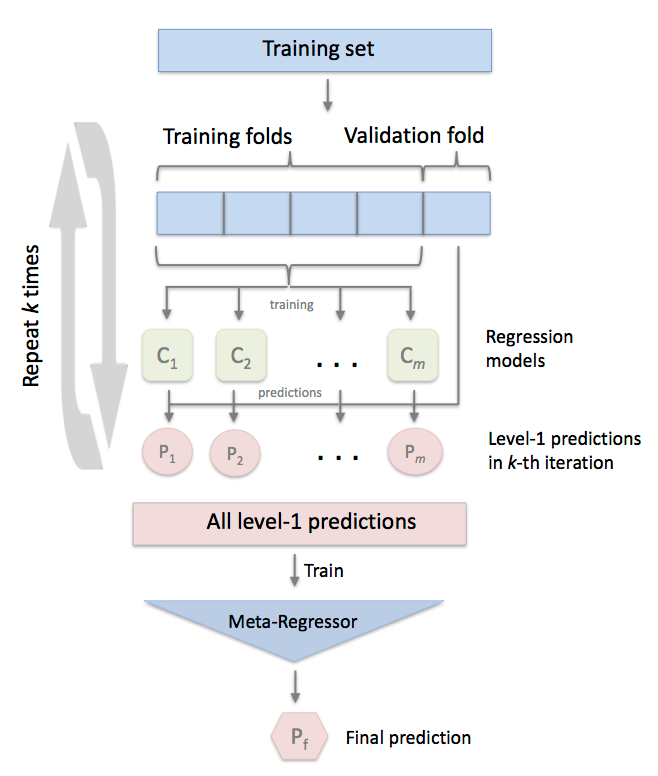

Reference: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

**Stacking Averaged models Score**

In [76]:
# ~ 10 minutes to run

#stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost_new, KRR), # adding RF here did not help
#                                                 meta_model = lasso)
# verify: this class uses out of fold predictions in the stacking method, so rows in dataset are split up betwen models and each row in dataset is only used once
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, BR), # adding RF here did not help
                                                 meta_model = R_new)

if (compare_models == 1):
    with MyTimer():
        if (competition == 'SR'):
            score = mae_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))
        else:
            score = rmsle_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [77]:
stacked_averaged_models

StackingAveragedModels(base_models=(Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('elasticnet',
                                                     ElasticNet(alpha=0.05,
                                                                l1_ratio=0.85,
                                                                max_iter=100,
                                                                random_state=3,
                                                                selection='random'))]),
                                    GradientBoostingRegressor(learning_rate=0.05,
                                                              loss='huber',
                                                              max_depth=4,
                                                              max_features='sqrt',
                                                              min_samples

use different function to calculate ensembles

In [78]:
use_Regressor = 0 # default - best score
#use_Regressor = 1 # StackingRegressor - worst score
#use_Regressor = 2 # StackingCVRegressor - middle score

if (use_Regressor == 1):
    from sklearn.ensemble import StackingRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 1
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=RidgeCV(**r))
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'cv': None, 'gcv_mode': 'auto', 'random_state': 99} #  
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(**r))

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test.values), lam_l)
    #reg.transform(inv_boxcox1p(stacked_averaged_models2, lam_l))
    print(stacked_pred)
    print(reg)

multilayer stacking

In [79]:
a='''
# Note Multiple stacking layers can be achieved by assigning final_estimator to a StackingClassifier or StackingRegressor:

final_layer = StackingRegressor(
    estimators=[('rf', RandomForestRegressor(random_state=42)),
                ('gbrt', GradientBoostingRegressor(random_state=42))],
    final_estimator=RidgeCV()
    )
multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
                ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
    final_estimator=final_layer
)
multi_layer_regressor.fit(X_train, y_train)'''

Use another Stacking function, from mlxtend

In [80]:
if (use_Regressor == 2):
    from mlxtend.regressor import StackingCVRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 0
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        enet = make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = RidgeCV(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'random_state': 99} #  
        enet = make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = Ridge(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test.values), lam_l)
    print(stacked_pred)
    print(reg)
    
    print('5-fold cross validation scores:\n')
    for clf, label in zip([enet, gboost, krr, br], ['enet', 'gboost', 
                                                'krr', 'br',
                                                'StackingCVRegressor']):
        scores = cross_val_score(clf, train, y_train, cv=5, scoring='neg_mean_squared_error')
        print("Neg. MSE Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
        #scores = cross_val_score(clf, train, y_train, cv=5)
        #print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the **StackedRegressor** defined previously. 

###Final Training and Prediction

**StackedRegressor:**

add the previous averaged models here

In [81]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
if (use_voting_regressor == 0):
    averaged_pred = inv_boxcox1p(averaged_models.predict(test.values), lam_l)

if (competition == 'SR'):
    print(mae(y_train, averaged_train_pred))
else:
    print(rmsle(y_train, averaged_train_pred))

2.583661622585178


In [82]:
#pre adjustment
averaged_pred

array([122580.82167104, 165518.65541358, 188617.41900606, ...,
       167005.45975803, 113219.74228136, 221108.89332417])

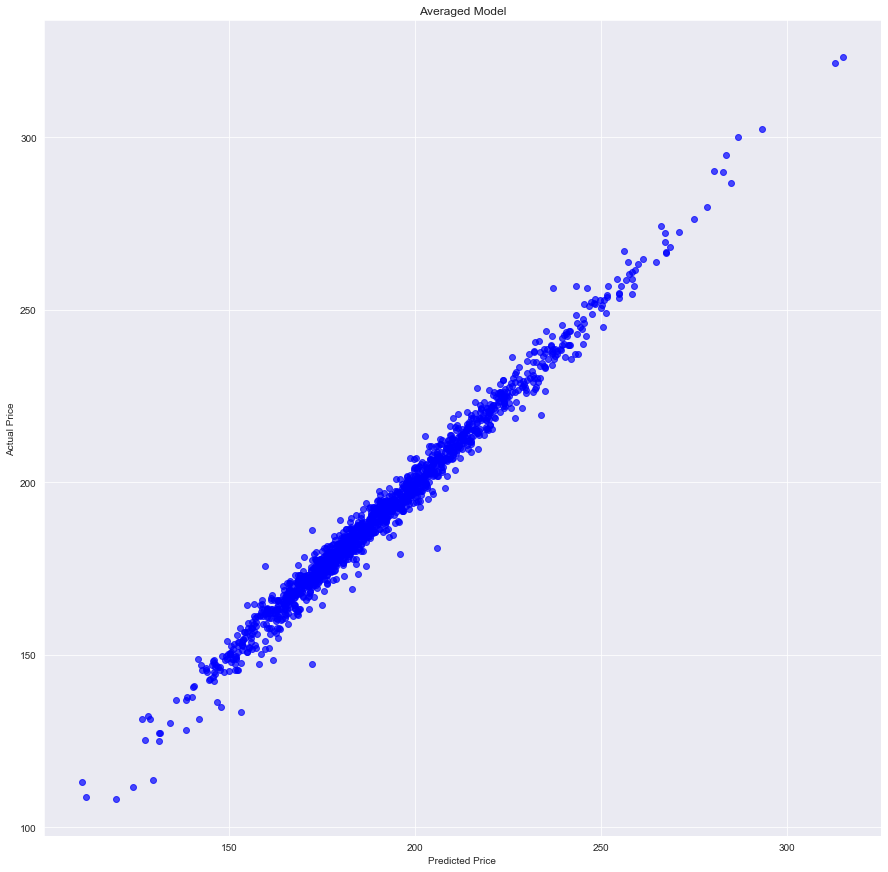

In [83]:
plt.figure(figsize=(15,15))
plt.scatter(averaged_train_pred, y_train, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')
plt.show()

Check predictions, are they on same scale as SalePrice in Train dataset?

In [84]:
averaged_models.predict(test.values)

array([169.67939553, 188.80189622, 197.76847663, ..., 189.40270757,
       164.94830448, 209.24488314])

In [85]:
averaged_train_pred

array([204.72032165, 194.42323283, 208.37334656, ..., 222.79086342,
       177.97576757, 182.76915589])

In [86]:
#post adjustment
averaged_pred

array([122580.82167104, 165518.65541358, 188617.41900606, ...,
       167005.45975803, 113219.74228136, 221108.89332417])

In [87]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
if (use_Regressor == 0):
    stacked_pred = inv_boxcox1p(stacked_averaged_models.predict(test.values), lam_l)
    
with MyTimer():
    if (competition == 'SR'):
        print(mae(y_train, stacked_train_pred))
    else:
        print(rmsle(y_train, stacked_train_pred))

out_of_fold_predictions [[204.26919235 205.64941267 205.45092258 203.54236946]
 [196.33751596 191.64483904 193.02548542 196.40533558]
 [207.2400321  205.16598471 208.2546137  207.44641725]
 ...
 [231.74622669 213.00004935 216.81664653 220.68592471]
 [177.13500493 178.43958575 170.21693908 175.76492909]
 [181.65163454 182.5132125  182.98024601 183.79617324]]
2.6090075682679914
The function took 0.0 seconds to complete


In [88]:
stacked_pred

array([119697.21608707, 172530.13027808, 187453.06095492, ...,
       163515.77580729, 110755.37298251, 220556.68401766])

In [89]:
print(y_train)
print(stacked_train_pred)
print(stacked_pred)

0      204.931
1      195.086
2      210.045
3      177.893
4      218.560
         ...  
1453   192.575
1454   205.453
1455   223.569
1456   178.848
1457   181.224
Name: SalePrice, Length: 1458, dtype: float64
[205.30374619 195.11557808 208.68254698 ... 223.58761348 177.5536241
 182.02056081]
[119697.21608707 172530.13027808 187453.06095492 ... 163515.77580729
 110755.37298251 220556.68401766]


In [90]:
def fit_pred(train, ytrain, test, model):
        model.fit(train, y_train)
        model_train_pred = model.predict(train)
        model_pred = inv_boxcox1p(model.predict(test), lam_l)
        return(model_train_pred, model_pred)
    
models = [CBoost, lasso, lasso_new, ENet, KRR, GBoost, GBoost_new, model_xgb, model_xgb_new, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B] # model_lgb,
model_names = ['CBoost', 'lasso', 'lasso_new', 'ENet', 'KRR', 'GBoost', 'GBoost_new', 'model_xgb', 'model_xgb_new', 'BR', 'ET', 'ET_new', 'RF', 'RF_new', 'AB', 'SVR', 'DT', 'KN', 'B']
df_train_pred = pd.DataFrame()
df_test_pred = pd.DataFrame()
with MyTimer():
    for i in range(0,len(models)):
        mn = model_names[i]+"_pred"
        train_pred, test_pred = fit_pred(train, y_train, test, models[i])
        df_train_pred[mn] = train_pred
        df_test_pred[mn] = test_pred
        #print(mn, test_pred)    


[20:24:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The function took 54.85115838050842 seconds to complete


In [91]:
# create dataframe with all these predictions to compare them
df_train_pred[:20]


,CBoost_pred,lasso_pred,lasso_new_pred,ENet_pred,KRR_pred,GBoost_pred,GBoost_new_pred,model_xgb_pred,model_xgb_new_pred,BR_pred,ET_pred,ET_new_pred,RF_pred,RF_new_pred,AB_pred,SVR_pred,DT_pred,KN_pred,B_pred
0,203.334,204.917,205.021,204.827,205.548,204.981,205.025,205.103,203.588,204.231,204.931,204.931,203.605,202.909,207.178,197.685,204.931,206.471,203.444
1,192.851,196.843,195.971,196.342,195.291,194.690,195.046,194.120,189.573,196.782,195.086,195.086,191.678,190.509,183.285,186.871,195.086,184.653,194.355
2,207.714,207.353,207.552,207.452,208.665,208.808,208.567,208.977,205.135,207.592,210.045,210.045,204.218,204.555,209.553,199.238,210.045,205.396,208.169
3,180.406,186.838,188.081,187.591,186.521,178.242,179.731,179.161,178.905,188.167,177.893,177.893,189.191,188.026,189.450,187.497,177.893,182.596,179.282
4,223.528,232.371,232.260,231.767,227.821,224.280,226.395,221.244,225.348,231.213,218.560,218.560,222.726,221.023,226.061,210.778,218.560,228.321,219.916
5,180.369,181.850,185.849,182.705,179.641,179.406,179.683,179.103,182.902,185.182,179.239,179.239,182.374,180.396,181.412,191.329,179.239,190.546,183.650
6,231.642,227.396,227.500,227.022,229.552,234.273,231.716,233.280,230.830,229.063,235.063,235.063,229.966,232.990,228.809,202.391,235.063,224.205,233.441
7,203.861,212.242,209.664,210.377,207.337,202.620,203.000,202.976,208.507,211.497,201.926,201.926,212.848,211.468,209.219,203.318,201.926,200.480,208.121
8,172.842,171.404,171.518,170.223,171.793,173.154,173.136,172.536,175.540,170.253,173.217,173.217,184.113,184.479,183.690,184.326,173.217,169.560,181.165
9,167.182,167.251,166.921,167.788,168.029,167.293,167.456,167.122,170.723,167.150,167.395,167.395,172.511,174.128,168.021,177.393,167.395,167.688,170.643


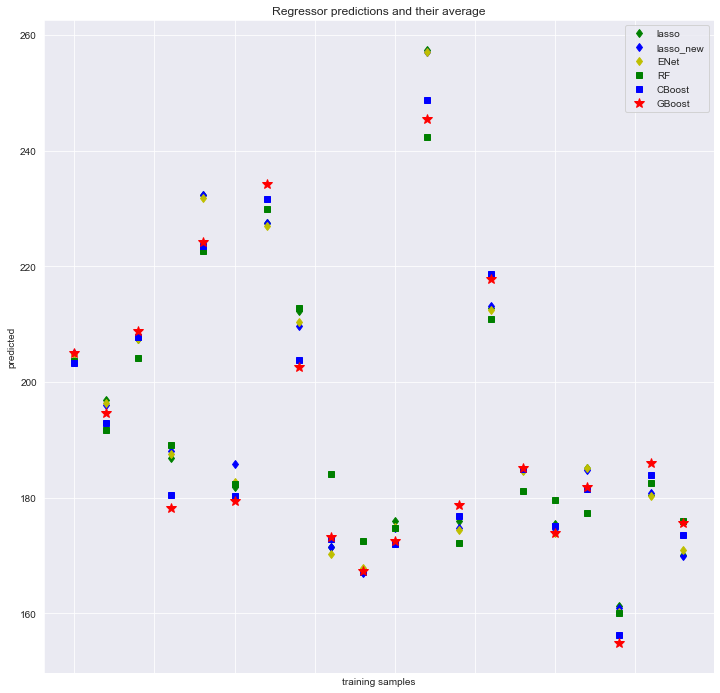

In [92]:
xt = df_train_pred[:20]

pred1 = xt['lasso_pred']
pred2 = xt['lasso_new_pred']
pred3 = xt['ENet_pred']
pred4 = xt['RF_pred']
pred5 = xt['CBoost_pred']
pred6 = xt['GBoost_pred']
plt.figure(figsize=(12,12))
plt.plot(pred1, 'gd', label='lasso')
plt.plot(pred2, 'bd', label='lasso_new')
plt.plot(pred3, 'yd', label='ENet')
plt.plot(pred4, 'gs', label='RF')
plt.plot(pred5, 'bs', label='CBoost')
plt.plot(pred6, 'r*', ms=10, label='GBoost')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

Create predictions for all models for testing

**XGBoost:**

In [93]:
# values are not normalized
train[train.columns].mean().head()

MSSubClass     2.305
LotFrontage    5.898
LotArea       19.549
Street         0.727
Alley          0.718
dtype: float64

In [94]:
# are train and test normalized? between -1 and 1
replace_xgb = 0 # new optimized model is worse, was overfit
if (replace_xgb == 1):
    model_xgb_new.fit(train, y_train)
    xgb_train_pred = model_xgb_new.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb_new.predict(test), lam_l)
else:
    model_xgb.fit(train, y_train)
    xgb_train_pred = model_xgb.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb.predict(test), lam_l)

if (competition == 'SR'):
    print(mae(y_train, xgb_train_pred))
else:
    print(rmsle(y_train, xgb_train_pred))

1.0002245014891895


**LightGBM:**

In [95]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = inv_boxcox1p(model_lgb.predict(test.values), lam_l)

if (competition == 'SR'):
    print(mae(y_train, lgb_train_pred))
else:
    print(rmsle(y_train, lgb_train_pred))

3.4257991540907495


In [96]:
if (tuning_lgb == 1):
    model_lgb_new.fit(train, y_train)
    lgb_train_pred_new = model_lgb_new.predict(train)
    lgb_pred_new = inv_boxcox1p(model_lgb_new.predict(test.values), lam_l)

    if (competition == 'SR'):
        print(mae(y_train, lgb_train_pred_new))
    else:
        print(rmsle(y_train, lgb_train_pred_new))

In [97]:
# compare values with optimization
print(lgb_train_pred)
if (tuning_lgb == 1):
    print(lgb_train_pred_new)
print(lgb_pred)
if (tuning_lgb == 1):
    print(lgb_pred_new)

[203.67611878 191.8459941  206.83074    ... 222.94048261 177.72033626
 186.0114241 ]
[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]


In [98]:
'''RMSE on the entire Train data when averaging'''
print('RMSLE score on train data:')

stk = 0.70
xgb = 0.15
lgb = 0.15

if (competition == 'SR'):
    print(mae(y_train,stacked_train_pred*stk + xgb_train_pred*xgb + lgb_train_pred*lgb ))
else:
    print(rmsle(y_train,stacked_train_pred*stk + xgb_train_pred*xgb + lgb_train_pred*lgb ))

RMSLE score on train data:
2.3862754681795746


**Ensemble prediction:**

when deciding which models to include in an ensemble:  
    fewer are better  
    more diverse are better
    low correlation between predictions is better (error correction)
    hyperparameter tuning is not as useful as it is for individual models (combining weak learners)

In [99]:
method = 'ensemble'
ensemble = averaged_pred

In [100]:
print(lgb_pred)
print(xgb_pred)
print(stacked_pred)
print(averaged_pred)
print(ensemble)

[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]
[129542.23 161702.94 188505.3  ... 174070.19 109318.1  222066.2 ]
[119697.21608707 172530.13027808 187453.06095492 ... 163515.77580729
 110755.37298251 220556.68401766]
[122580.82167104 165518.65541358 188617.41900606 ... 167005.45975803
 113219.74228136 221108.89332417]
[122580.82167104 165518.65541358 188617.41900606 ... 167005.45975803
 113219.74228136 221108.89332417]


In [101]:
print(y_train,stacked_train_pred * stk + xgb_train_pred * xgb + lgb_train_pred * lgb) # if using averaged_pred, need to add averaged_pred here
print(y_train,stacked_train_pred)

0      204.931
1      195.086
2      210.045
3      177.893
4      218.560
         ...  
1453   192.575
1454   205.453
1455   223.569
1456   178.848
1457   181.224
Name: SalePrice, Length: 1458, dtype: float64 [205.02943436 194.47573704 208.44888665 ... 223.52537317 177.78021828
 182.46781669]
0      204.931
1      195.086
2      210.045
3      177.893
4      218.560
         ...  
1453   192.575
1454   205.453
1455   223.569
1456   178.848
1457   181.224
Name: SalePrice, Length: 1458, dtype: float64 [205.30374619 195.11557808 208.68254698 ... 223.58761348 177.5536241
 182.02056081]


Plot prediction vs actual for train for one last verification of the model

In [102]:
sub_train = pd.DataFrame()
sub_train['Id'] = train_ID
sub_train['SalePrice'] = inv_boxcox1p(averaged_train_pred, lam_l)

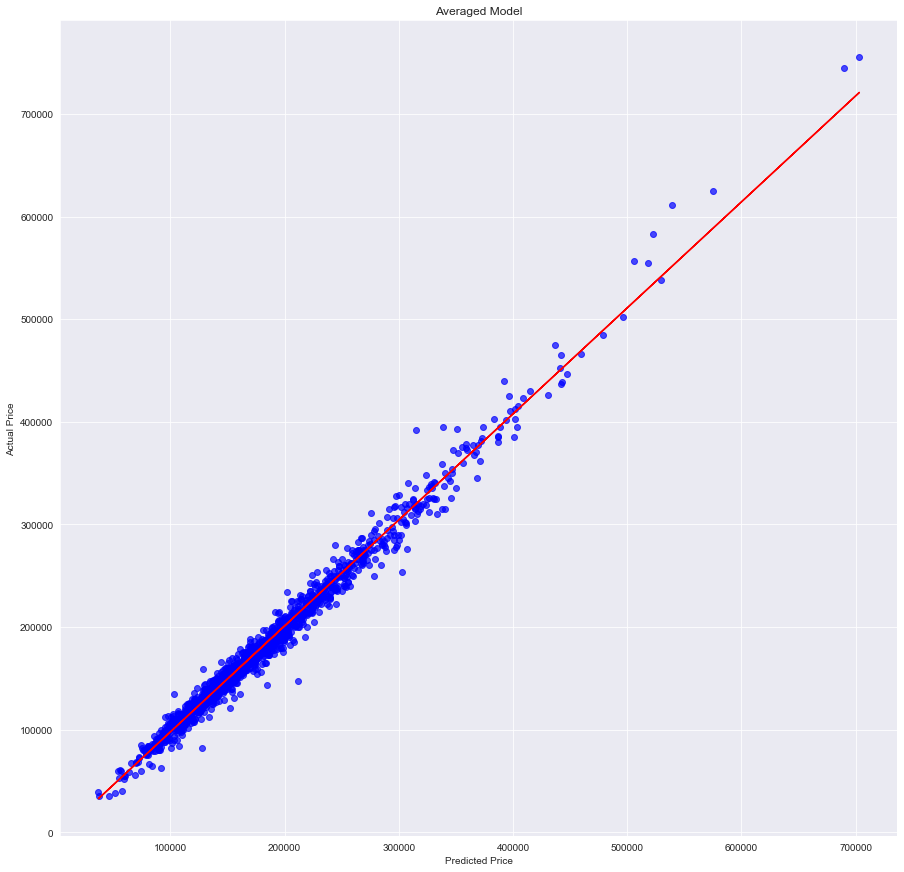

In [103]:
Predicted = sub_train['SalePrice']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

At the high end, SP > 520000, the model predicts too low for 7/8 points

Get Pre-adjustment score for comparison

In [104]:
# Pre-adjustment score
print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice']))
print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice']))
print("mae for SalePrice",mae(Actual, Predicted))
print("mse for SalePrice",rmsle(Actual, Predicted))

mae for boxcox(SalePrice) 180265.54520972964
mse for boxcox(SalePrice) 195761.1889422766
mae for SalePrice 6729.1151956432695
mse for SalePrice 10061.037823069613


Find best cutoff and adjustment at high end

In [105]:
def AdjustHigh(sub_train, y_train):
    AdjustedScores = []
    for i in np.arange(.994, 1.000, 0.01):
        for j in np.arange(1.00, 1.10, .01):

            q1 = sub_train['SalePrice'].quantile(0.0025)
            q2 = sub_train['SalePrice'].quantile(0.0045)
            q3 = sub_train['SalePrice'].quantile(i)

            #Verify the cutoffs for the adjustment
            print(q1,q2,q3)
            # adjust at low end
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

            # adjust at high end
            sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

            Predicted = sub_train['SalePrice2']
            Actual = inv_boxcox1p(y_train, lam_l)

            # Pre-adjustment score
            #print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
            #print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
            #print("mae for SalePrice",mae(Actual, Predicted))
            #print("mse for SalePrice",rmsle(Actual, Predicted))

            AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])

    df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])
    print('quantiles vs coefficients')
    df_adj.sort_values(by=['RMSE_BC'])
    print(df_adj)
    df2 = df_adj.sort_values(by=['RMSE_BC']).reset_index()
    coef_hi = df2.COEF[0]
    quant_hi = df2.QUANT[0]
    return (coef_hi, quant_hi)

ch, qh = AdjustHigh(sub_train, y_train)

52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
52900.00569247706 56267.76383943122 483064.7739842496
quantiles vs coefficients
    QUANT  COEF  MAE_BC  RMSE_BC   MAE_SP   RMSE_SP
0   0.994 1.000   2.584    3.607 6729.115 10061.038
1   0.994 1.010   2.577    3.594 6694.276  9915.943
2   0.994 1.020   2.573    3.584 6668.476  9789.145
3   0.994 1.030   2.569    3.575 6647.710  9681.360
4   0.994 1.040   2.566    3.568 6626.943  9593.231
5   0.994 1.050   2.562    3.562 6606.176  9525.303
6   0.994 1.060 

In [106]:
print('ch',ch)
print('qh',qh)

ch 1.08
qh 0.994


In [107]:
q1 = sub_train['SalePrice'].quantile(0.0015)
q2 = sub_train['SalePrice'].quantile(0.01)
q3 = sub_train['SalePrice'].quantile(qh)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*ch)

46899.369093867674 69329.40966983451 483064.7739842496


Show adjustments

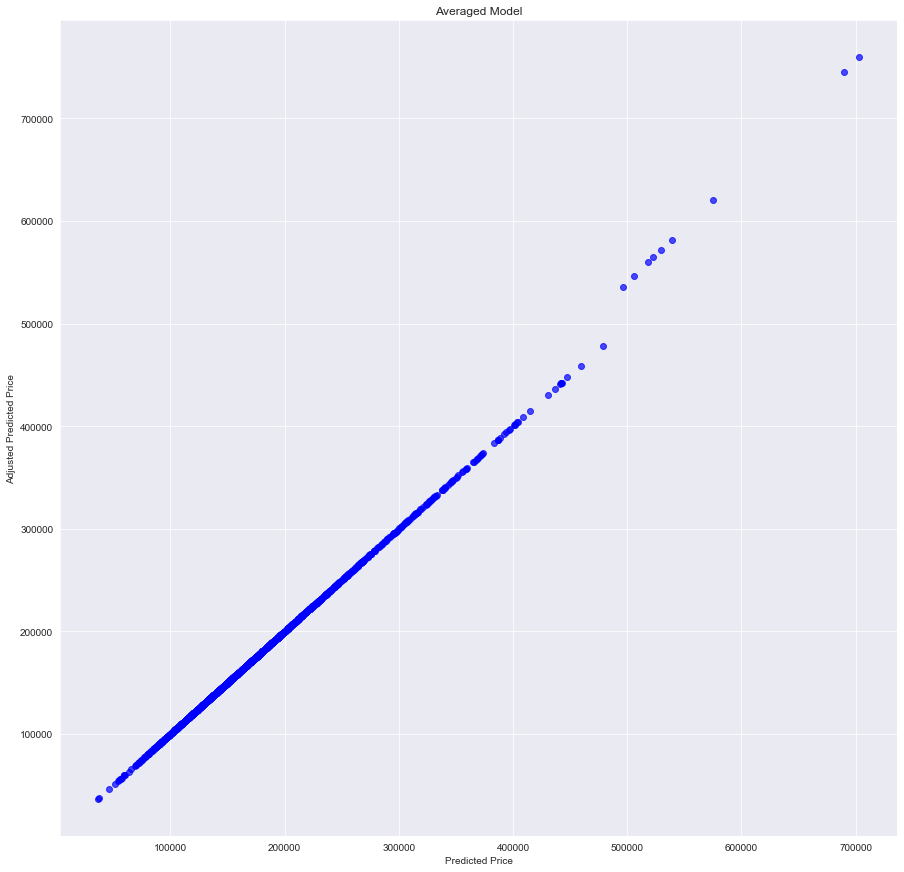

In [108]:
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

We have bumped up the predictions and they look correct so far, now to verify on the previous chart

In [109]:
sub_train.query("SalePrice != SalePrice2")

,Id,SalePrice,SalePrice2
178,179,496335.220,536042.038
440,441,518432.869,559907.499
690,692,703203.183,759459.438
768,770,529573.968,571939.886
802,804,522924.785,564758.767
897,899,538819.508,581925.069
1045,1047,505838.026,546305.068
1168,1170,574825.668,620811.722
1181,1183,689648.035,744819.878


Show new predictions

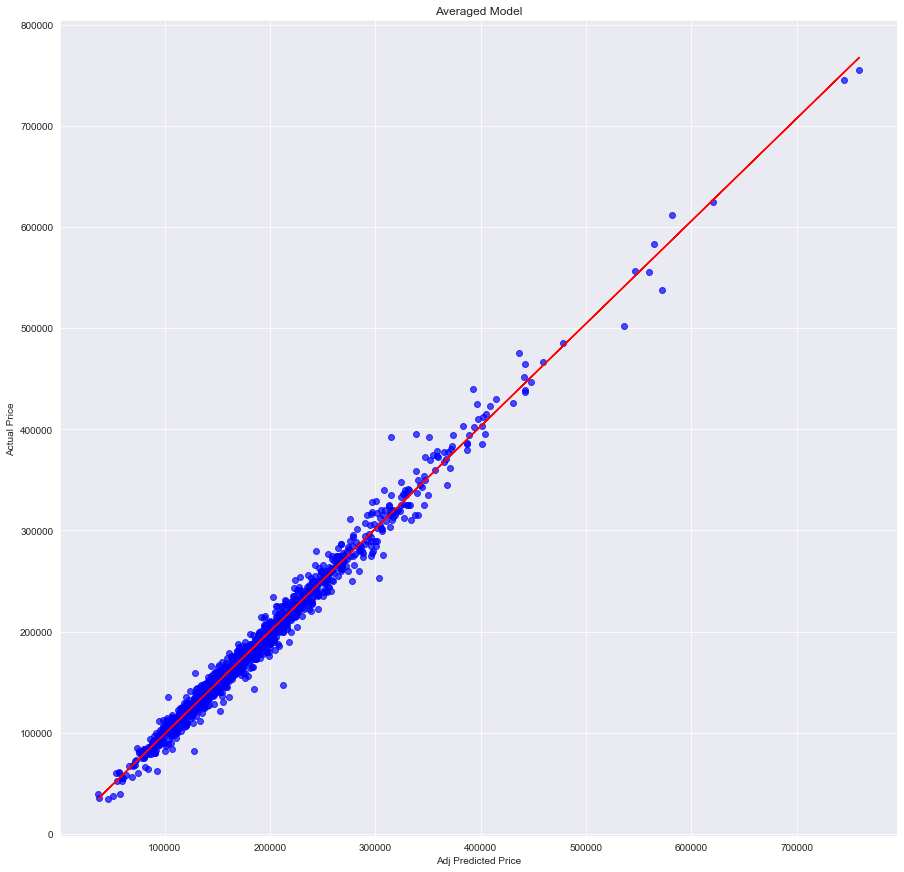

In [110]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

correlation looks much better at the high end

In [111]:
# Post adjustment for high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180544.2613283684
mse for boxcox(SalePrice2) 196608.86893729572
mae for SalePrice2 6556.725359746549
mse for SalePrice2 9446.435982622324


Now try to improve upon this

Find best cutoff and adjustment at low end

In [112]:
def AdjustLow(sub_train, y_train):
    AdjustedScores = []
    for i in np.arange(.00, .02, 0.001):
        for j in np.arange(.90, 1.10, 0.01):

            q1 = sub_train['SalePrice'].quantile(i)
            q2 = sub_train['SalePrice'].quantile(0.1)
            q3 = sub_train['SalePrice'].quantile(.995)

            #Verify the cutoffs for the adjustment
            #print(q1,q2,q3)
            # adjust at low end
            sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*j)
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

            # adjust at high end
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

            Predicted = sub_train['SalePrice2']
            Actual = inv_boxcox1p(y_train, lam_l)

            # Pre-adjustment score
            #print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
            #print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
            #print("mae for SalePrice",mae(Actual, Predicted))
            #print("mse for SalePrice",rmsle(Actual, Predicted))

            AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])
  
    df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])
    print('quantiles vs coefficients')
    df_adj.sort_values(by=['RMSE_BC'])
    print(df_adj)
    df2 = df_adj.sort_values(by=['RMSE_BC']).reset_index()
    coef_lo = df2.COEF[0]
    quant_lo = df2.QUANT[0]
    return (coef_lo, quant_lo)

cl, ql = AdjustLow(sub_train, y_train)

quantiles vs coefficients
     QUANT  COEF  MAE_BC  RMSE_BC   MAE_SP   RMSE_SP
0    0.000 0.900   2.586    3.611 6731.645 10062.109
1    0.000 0.910   2.586    3.610 6731.392 10061.960
2    0.000 0.920   2.586    3.610 6731.139 10061.821
3    0.000 0.930   2.586    3.609 6730.886 10061.690
4    0.000 0.940   2.585    3.609 6730.633 10061.569
..     ...   ...     ...      ...      ...       ...
415  0.019 1.060   2.602    3.656 6754.596 10088.461
416  0.019 1.070   2.608    3.668 6762.882 10095.845
417  0.019 1.080   2.615    3.680 6771.627 10104.028
418  0.019 1.090   2.621    3.694 6780.431 10113.010
419  0.019 1.100   2.628    3.709 6790.770 10122.787

[420 rows x 6 columns]


In [113]:
print('cl',cl)
print('ql',ql)

cl 0.92
ql 0.01


In [114]:
q1 = sub_train['SalePrice'].quantile(ql)
q2 = sub_train['SalePrice'].quantile(0.1)
q3 = sub_train['SalePrice'].quantile(qh)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end

#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x > q1 and x < q3) else x*cl) 
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x > q1) else x*cl) 
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x < q3 and x > q1) else x*ch)
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x < q3) else x*ch)
sub_train.query("SalePrice != SalePrice2")

69329.40966983451 105789.19568141828 483064.7739842496


,Id,SalePrice,SalePrice2
178,179,496335.220,536042.038
440,441,518432.869,559907.499
690,692,703203.183,759459.438
768,770,529573.968,571939.886
802,804,522924.785,564758.767
897,899,538819.508,581925.069
1045,1047,505838.026,546305.068
1168,1170,574825.668,620811.722
1181,1183,689648.035,744819.878


In [115]:
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x > q1 and x < q3) else x*cl) 
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x*cl if x < q1 else ( x*ch if x > q3 else x))

#                                                       lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)

sub_train.query("SalePrice != SalePrice2")

,Id,SalePrice,SalePrice2
30,31,57457.519,52860.918
178,179,496335.220,536042.038
375,376,56002.537,51522.334
440,441,518432.869,559907.499
495,496,45935.822,42260.956
532,534,36884.175,33933.441
619,621,65638.824,60387.718
635,637,53884.791,49574.008
690,692,703203.183,759459.438
704,706,60013.369,55212.299


Show both adjustments

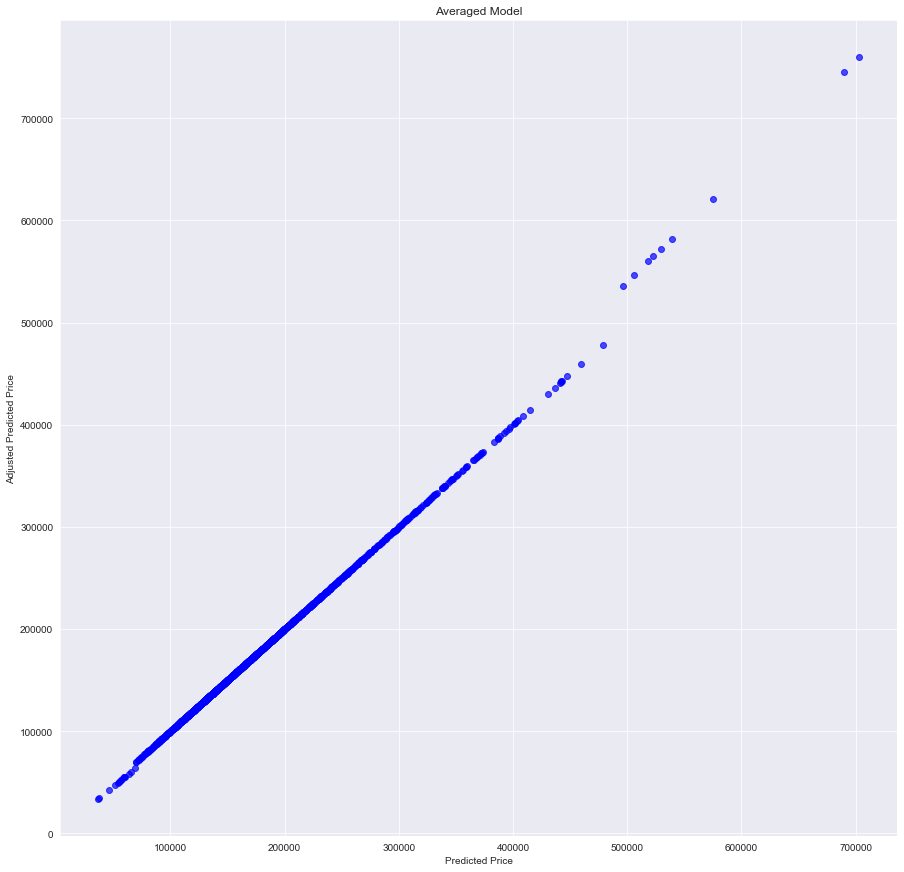

In [116]:
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

Show new predictions

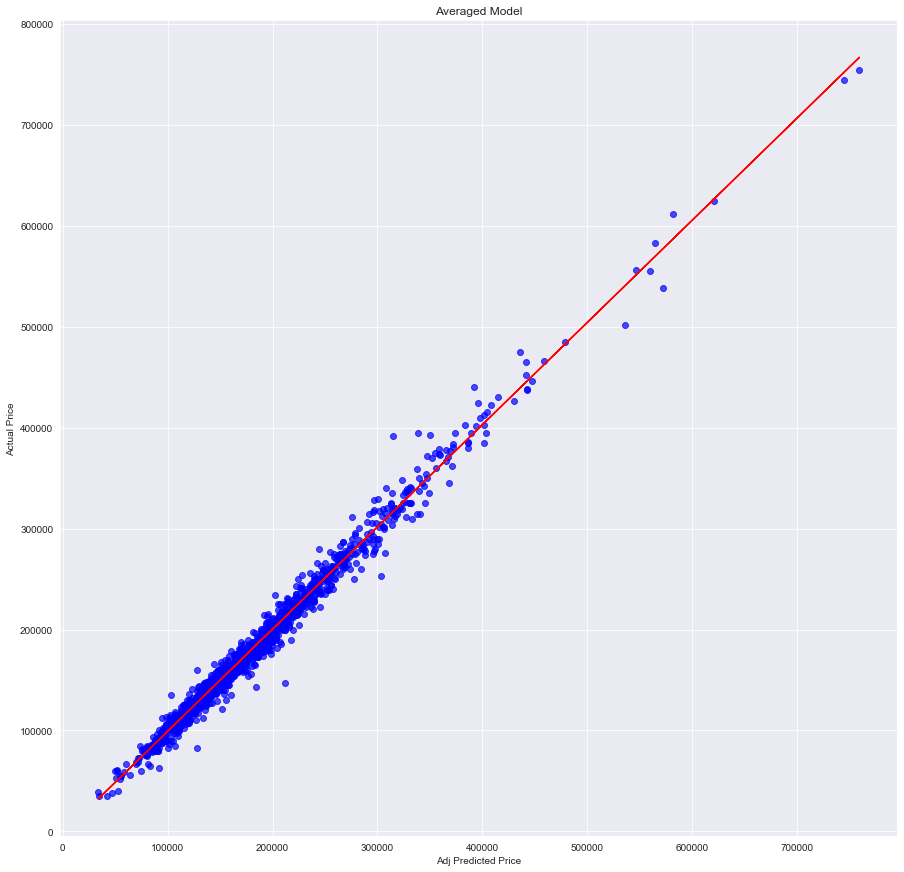

In [117]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')

plt.show()

In [118]:
sub_train.query("SalePrice != SalePrice2")

,Id,SalePrice,SalePrice2
30,31,57457.519,52860.918
178,179,496335.220,536042.038
375,376,56002.537,51522.334
440,441,518432.869,559907.499
495,496,45935.822,42260.956
532,534,36884.175,33933.441
619,621,65638.824,60387.718
635,637,53884.791,49574.008
690,692,703203.183,759459.438
704,706,60013.369,55212.299


In [119]:
# Post adjustment for low and high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180498.82329190357
mse for boxcox(SalePrice2) 196596.33204609004
mae for SalePrice2 6544.636485125336
mse for SalePrice2 9435.902423802336


**Create File for Submission to Kaggle**

In [120]:
sub = pd.DataFrame()
#sub['Id'] = test['Id']
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
#sub.to_csv('submission.csv',index=False)

In [121]:
test

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.056,6.221,20.479,0.730,0.730,1.541,0.000,2.056,2.056,14.121,...,0,0,0,1,0,0,0,0,1,0
1,2.056,6.245,21.327,0.730,0.730,0.000,0.000,2.260,2.056,14.117,...,0,0,0,1,0,0,0,0,1,0
2,2.886,6.073,21.197,0.730,0.730,0.000,0.000,2.056,1.820,14.178,...,0,0,0,1,0,0,0,0,1,0
3,2.886,6.173,19.865,0.730,0.730,0.000,0.000,2.260,2.056,14.180,...,0,0,0,1,0,0,0,0,1,0
4,0.000,5.094,17.257,0.730,0.730,0.000,0.000,2.603,1.820,14.170,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.194,3.933,14.081,0.730,0.730,1.541,0.000,1.820,2.260,14.136,...,0,0,0,1,0,0,0,0,1,0
1455,1.194,3.933,14.013,0.730,0.730,1.541,0.000,1.820,1.820,14.136,...,0,0,0,1,1,0,0,0,0,0
1456,2.056,7.620,22.782,0.730,0.730,1.541,0.000,2.056,2.260,14.120,...,0,0,0,1,1,0,0,0,0,0
1457,3.341,5.744,20.047,0.730,0.730,1.541,0.000,2.056,1.820,14.170,...,0,0,0,1,0,0,0,0,1,0


try a 50% adjustment on the low end

In [122]:
#cl = (1.0 + cl)/2

Making the same adjustment on the test data for our submission

In [123]:
adjust_both = 0
adjust_low = 0
adjust_high = 1

q1 = sub['SalePrice'].quantile(ql)
q2 = sub['SalePrice'].quantile(0.1)
q3 = sub['SalePrice'].quantile(qh)

if (adjust_both == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x*cl if (x < q1) else ( x*ch if (x > q3) else x))
elif (adjust_low == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if (x > q1) else x*cl) 
elif (adjust_high == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if (x < q3) else x*ch)
else:
    print("no adjustments made")

In [124]:
sub.to_csv('submission.csv',index=False)

In [125]:
sub.head()

,Id,SalePrice
0,1461,122580.822
1,1462,165518.655
2,1463,188617.419
3,1464,193843.754
4,1465,193626.418


In [126]:
!pwd

/c/DataScience/Repo/StackedRegression


In [127]:
ls -arlt

 Volume in drive C is Windows
 Volume Serial Number is DC83-883D

 Directory of C:\DataScience\Repo\StackedRegression



File Not Found


In [128]:
!head -10 submission.csv

Id,SalePrice
1461,122580.82167104141
1462,165518.65541357963
1463,188617.41900606322
1464,193843.75366623403
1465,193626.41820781844
1466,173283.10726328436
1467,176248.7700730779
1468,163246.15761496307
1469,180459.50531262855


In [129]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-07-31 20:13:05.801226
End:  2020-07-31 20:24:36.619584


In [130]:
from mlens.ensemble import SuperLearner
new_ensemble = SuperLearner(random_state=1, verbose=2)

[MLENS] backend: threading


In [138]:
CBoost_new.get_params()

{'learning_rate': 0.025,
 'depth': 5,
 'l2_leaf_reg': 1.0,
 'loss_function': 'RMSE',
 'logging_level': 'Silent',
 'random_strength': 3.7,
 'eval_metric': 'RMSE',
 'bagging_temperature': 1.0,
 'bootstrap_type': 'Bayesian',
 'n_estimators': 1700,
 'random_state': 15,
 'grow_policy': 'SymmetricTree'}

In [135]:
train

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.886,5.831,19.212,0.730,0.730,1.541,0.000,2.440,1.820,14.188,...,0,0,0,1,0,0,0,0,1,0
1,2.056,6.221,19.712,0.730,0.730,1.541,0.000,2.260,2.440,14.145,...,0,0,0,1,0,0,0,0,1,0
2,2.886,5.915,20.347,0.730,0.730,0.000,0.000,2.440,1.820,14.184,...,0,0,0,1,0,0,0,0,1,0
3,3.011,5.685,19.692,0.730,0.730,0.000,0.000,2.440,1.820,14.048,...,0,0,0,1,1,0,0,0,0,0
4,2.886,6.315,21.325,0.730,0.730,0.000,0.000,2.603,1.820,14.183,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2.886,5.744,18.961,0.730,0.730,1.541,0.000,2.260,1.820,14.181,...,0,0,0,1,0,0,0,0,1,0
1454,2.056,6.338,20.995,0.730,0.730,1.541,0.000,2.260,2.056,14.148,...,0,0,0,1,0,0,0,0,1,0
1455,3.011,5.860,19.476,0.730,0.730,1.541,0.000,2.440,2.603,14.089,...,0,0,0,1,0,0,0,0,1,0
1456,2.056,5.915,19.760,0.730,0.730,1.541,0.000,2.056,2.056,14.104,...,0,0,0,1,0,0,0,0,1,0


In [136]:
y_train

0      204.931
1      195.086
2      210.045
3      177.893
4      218.560
         ...  
1453   192.575
1454   205.453
1455   223.569
1456   178.848
1457   181.224
Name: SalePrice, Length: 1458, dtype: float64

In [137]:
test

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.056,6.221,20.479,0.730,0.730,1.541,0.000,2.056,2.056,14.121,...,0,0,0,1,0,0,0,0,1,0
1,2.056,6.245,21.327,0.730,0.730,0.000,0.000,2.260,2.056,14.117,...,0,0,0,1,0,0,0,0,1,0
2,2.886,6.073,21.197,0.730,0.730,0.000,0.000,2.056,1.820,14.178,...,0,0,0,1,0,0,0,0,1,0
3,2.886,6.173,19.865,0.730,0.730,0.000,0.000,2.260,2.056,14.180,...,0,0,0,1,0,0,0,0,1,0
4,0.000,5.094,17.257,0.730,0.730,0.000,0.000,2.603,1.820,14.170,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.194,3.933,14.081,0.730,0.730,1.541,0.000,1.820,2.260,14.136,...,0,0,0,1,0,0,0,0,1,0
1455,1.194,3.933,14.013,0.730,0.730,1.541,0.000,1.820,1.820,14.136,...,0,0,0,1,1,0,0,0,0,0
1456,2.056,7.620,22.782,0.730,0.730,1.541,0.000,2.056,2.260,14.120,...,0,0,0,1,1,0,0,0,0,0
1457,3.341,5.744,20.047,0.730,0.730,1.541,0.000,2.056,1.820,14.170,...,0,0,0,1,0,0,0,0,1,0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:  5.3min finished

[2020-07-31 20:31:45] Features: 1/50 -- score: -235.74105066907396[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed: 14.1min finished

[2020-07-31 20:45:52] Features: 2/50 -- score: -144.87159640174195[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed: 16.4min finished

[2020-07-31 21:02:15] Features: 3/50 -- score: -121.54539375986181[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

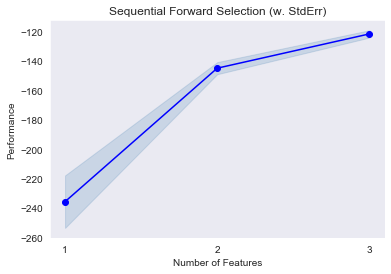

In [140]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# accuracy levels off at k_features=25, this code takes several hours to run!!
feature_select = 1
if (feature_select == 1):
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS

    sfs1 = SFS(CBoost_new, 
               k_features=2, 
               forward=True, 
               floating=False, 
               verbose=2,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(train, y_train)

    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    import matplotlib.pyplot as plt

    fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()


In [ ]:
if (feature_select == 1):
    # Generate the new subsets based on the selected features
    # Note that the transform call is equivalent to
    # X_train[:, sfs1.k_feature_idx_]

    X_train_sfs = sfs1.transform(train)
    X_test_sfs = sfs1.transform(test)

    # Fit the estimator using the new feature subset
    # and make a prediction on the test data
    CBoost_new.fit(X_train_sfs, y_train)
    y_train_pred = CBoost_new.predict(X_train_sfs)
    y_pred = CBoost_new.predict(X_test_sfs)

    # Compute the accuracy of the prediction
    #classification
    #acc = float((y_train == y_pred).sum()) / y_pred.shape[0]
    #print('Test set accuracy: %.2f %%' % (acc * 100))
    #regression
    print("mae",mae(y_train, y_train_pred))
    print("rmsle",rmsle(y_train, y_train_pred))

In [133]:
print("End: ", datetime.datetime.now())

End:  2020-07-31 20:24:43.800109


<pre>
1)  11903.16032     Original
2)  12003.62416     replace GBoost_orig with GBoost in averaged_models, and replace random_state=None to =5, model_lgb add random_state=10 
3b) 11883.76866     revert to #1, GBoost -> GBoost_new and GBoost -> GBoost for consistency, optimize high predictions (low is better unoptimized)
4)  11946.35507     replace KRR with KRR_new, try to use sub_train and val split on test to optimize parameters, then fit on entire dataset to test for overfitting issues
5)  11903.16032     revert to #1 using KRR (why is the score better in averaging by using KRR when KRR by itself is worse than KRR_new
6)  11928.28531     use both KRR and KRR_new
7)  12051.55956     remove KRR entirely
8)  13271.42904     use only KRR,KRR but this time using the AveragedModels class, maybe this class is not working correctly (score was 13334.05768 using direct submit)
9)  13072.80203     try KRR_new,KRR_new and compare to krr_new_submission.csv (krr_submission.csv should match submission_Ensemble_8.csv), both match so class should be fine (score was 13183.75855 using direct submit)
10) 12256.25090     add model_lgb, remove one of the KRR_new entries
11) 12042.74366     add model_xgb
12) 12007.46670     add GBoost
13) 11946.35507     add BayesianRidge
14) 13045.22300     use model_lgb only
15) 12941.35767     model_xgb only
16) 13092.89778     GBoost only
17) 13256.71876     GBoost_new only
18) 13740.87267     BR - BayesianRidge only
19) 13733.06706     ENet only
20) 13986.40310     lasso only
21) 13684.37444     lasso_new only
22) 13749.48557     R_new only
23) 14479.45483     ET only
24) 18102.47375     RF_new only
25) 12311.55920     KRR, model_lgb 
26) 12037.20264     KRR, model_lgb, model_xgb
27) 12014.43498     KRR, model_lgb, model_xgb, GBoost
28) 11903.16032     KRR, model_lgb, model_xgb, GBoost, BR
29) 12559.94022     model_xgb, model_lgb
30) 12421.14142     model_xgb, model_lgb, GBoost
31) 12014.43498     model_xgb, model_lgb, GBoost, KRR
32) 11903.16032     model_xgb, model_lgb, GBoost, KRR, BR
33) 11876.36113     automatically choose optimal coef,quant for high and low predictions, minimizing RMSE, fix for adjusting high and low together
34) 11855.61218     adjust high only
35) 11863.44483     adjust 50% of low
36) 11855.61218     revert to adjust high only, as it seems to be best for averaged_scores, will revisit this later, use VotingRegressor instead of AveragingModels
37) 12130.76543     AveragingModels with median, add plots to compare different predictions
38) 12863.25877     revert to mean, use Catboost only
39) 11926.40629     add CBoost to group (all 6)
40) 13238.18495     KRR only
41) 12253.28151     KRR,CBoost
42) 12179.55993     KRR,CBoost,model_lgb
43) 12113.77511     KRR,CBoost,model_lgb,model_xgb
44) 11947.52325     KRR,CBoost,model_lgb,model_xgb,BR
45) 12101.78494     KRR,CBoost,model_lgb,model_xgb,GBoost
46) 12052.66897     KRR,CBoost,model_lgb,model_xgb,GBoost,BR with no adjustments
47) 11926.40629     revert to #39, with adjustments
48) 12863.25877     optimize CBoost, use CBoost_def only (later try CBoost_mae, CBoost_new) - 48a) redo with random_state=0
49) 12305.30361     CBoost_new only - 49a) redo with random_state=0
50) 12633.27748     CBoost_mae only
51) 12305.30361     CBoost_new set random_state=0, was i (inconsistent), general cleanup of CBoost testing
52) 11856.10096     use CBoost_new in group KRR,CBoost_new,model_lgb,model_xgb,GBoost,BR
53) 12064.66438     CBoost_new,KRR
54) 11942.91109     CBoost_new,KRR,model_xgb
55) 11886.77642     CBoost_new,KRR,model_xgb,BR
56) 11999.04397     try different 4th model: CBoost_new,KRR,model_xgb,model_lgb
57) 11954.45590     try another 4th model: CBoost_new,KRR,model_xgb,GBoost
58) 11886.43881     missing data point CBoost_new,KRR,model_xgb,BR,model_lgb
59) 11831.45710     try another 5th model: CBoost_new,KRR,model_xgb,BR,GBoost
60) 11880.64605     swap model_xgb with model_lgb
61) 11791.69189     revert to model_xgb, try ENet again as 6th model: CBoost_new,KRR,model_xgb,BR,GBoost,ENet
62) 11860.81921     try lasso_new as 6th model: CBoost_new,KRR,model_xgb,BR,GBoost,lasso_new
63) 11822.36441     original lasso
64) 11869.10592     use both lasso and ENet: CBoost_new,KRR,model_xgb,BR,GBoost,lasso,ENet
65) 11791.69189     remove lasso, use VotingRegressor with same 6 models
66) 11852.95999     CBoost_new random_state=21 (was 0)
67) 11816.73190     random_state=88
68) 11747.97055     random_state=15
69) 11747.97055     change ratios, but keep them even (use CBoost 2x, but gets weight=1, the rest get weight=2)
70) 11763.60208     use random_state=10 and 15 for 2 CBoost models, score is average of the 2 as expected
71) 11734.49552*    remove 2nd CBoost, give CBoost a wt=3, others wt=2: weight_list = [3,2,2,2,2,2]
72) 11711.80408     CBoost=4, other wt=2: weight_list = [4,2,2,2,2,2]
73) 11655.28630**   model_xgb: random_state=2, save models to disk to use later



compare nmse for train for new vs old models, test is worse for new, is train also worse (underfit), or better (overfit)?

*** best score overall, stacking
** best score for averaging only



find and try other ridge regression and lasso regression algorithms and techniques

done:   
    try pca on features => no improvement in score. will drop this for now
    change ratios of models to find which is best predictor (gives best score), then work on improving that model first
    change scale factor of 3 models => score does not correlate to rmsle, try to find a better metric
    try StandardScaler and np.clip on features, currently see RobustScaler() being used but i already screened fliers so StandardScaler should be adequate
    more filtering of fliers
    try median in AveragingModels [or VotingRegressor?] - lower score
    check weights (use CBoost_new twice and give each half the weight of the others
    try to run same algorithm with different random_states and take average for prediction

to do:
    find other random_state values with better scores
    test other weighting patterns
    try other regressors: 
        reference: https://www.listendata.com/2018/03/regression-analysis.html
    GLM
        reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py
    need to investigate why using BoxCox1p is (slightly) better than the evaluation metric further...  
    try different pipelines, scaler, etc
        reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
    
    ideas from other kernels:

    add new features for non-linear features (OverallQual, etc) add a new column with log or square of feature
       
    tune min_samples_leaf and min_samples_split for GradientBoostingRegressor!
    
    add linear regression from here: https://github.com/chouhbik/Kaggle-House-Prices/blob/master/Kaggle-house-prices-KamalChouhbi.ipynb
    
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/    
    
Look at this later for deep learning stacking: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


try different pipelines, scaler, etc
reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

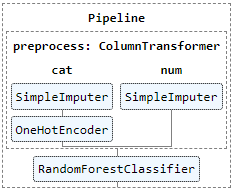

Try polynomial features:
reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py

from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=degrees[i],
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                         scoring="neg_mean_squared_error", cv=10)       
                             
                             
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lda', LinearDiscriminantAnalysis()))
model = Pipeline(estimators)    


features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model = Pipeline(estimators)

Try feature selection:

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/